# FlexDamage: Step-by-Step Tutorial

This notebook provides a granular, step-by-step guide to using the `flexdamage` library components individually. Instead of running the black-box `EstimationPipeline.run()`, we will manually orchestrate each stage of the process. This is useful for debugging, research, and understanding the internal data flow.

## Workflow Steps
1. **Mock Data Generation**: Create synthetic data with real country ISO codes.
2. **Setup**: Initialize configuration and logging.
3. **Data Loading & Preprocessing**: Load data, transform (scale), and aggregate (e.g., over GCMs).
4. **Global Estimation**: Estimate the global Gamma parameter (Income Elasticity).
5. **Regional Estimation**: Estimate regional response curves (with Convexity Constraints).
6. **Diagnostics**: Generate diagnostic plots and statistics tables.
7. **F2 Tables**: Generate projection tables.
8. **Map Visualizations**: Create choropleth maps and comparison plots.

In [1]:
import sys
import shutil
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure package is discoverable
project_root = Path("../").resolve()
sys.path.append(str(project_root))

from flexdamage.config.loader import load_config
from flexdamage.core.pipeline import EstimationPipeline
from flexdamage.core.global_est import GlobalEstimator
from flexdamage.core.regional import RegionalEstimator
from flexdamage.data.backends import PandasBackend
from flexdamage.data.preprocessing import DataPreprocessor
from flexdamage.core.f2_gen import F2Generator
from flexdamage.utils.logging import setup_logging
from flexdamage.diagnostics.plots import plot_gamma_distribution, plot_parameter_distributions, plot_prediction_curves, plot_damages_by_scenario
from flexdamage.diagnostics import DiagnosticVisualizer, MapVisualizer

# Setup output directory
base_dir = Path("step_by_step_output")
if base_dir.exists():
    shutil.rmtree(base_dir)
base_dir.mkdir()
data_dir = base_dir / "data"
data_dir.mkdir()
results_dir = base_dir / "results"
results_dir.mkdir()
diag_dir = results_dir / "diagnostics"
diag_dir.mkdir()
f2_dir = results_dir / "f2"
f2_dir.mkdir()
maps_dir = results_dir / "maps"
maps_dir.mkdir()

setup_logging(level="INFO")

2026-01-15 16:52:25 | INFO     | flexdamage | Logging initialized (Level: INFO)


## 1. Mock Data Generation

We generate synthetic mortality data using **real ISO-3 country codes** with a U-shaped temperature response.
The dataset includes GDP variables and transformations (`loggdppc`, `lgdp_delta`) as required for Global Estimation where Gamma represents Income Elasticity.

In [2]:
print("Generating Mock Data with Real Country ISO Codes...")
n = 3000
np.random.seed(42)

# Real ISO-3 country codes (diverse selection across regions)
COUNTRIES = [
    "USA", "CAN", "MEX", "BRA", "ARG",  # Americas
    "GBR", "FRA", "DEU", "ITA", "ESP",  # Western Europe
    "RUS", "POL", "UKR", "CZE", "HUN",  # Eastern Europe
    "CHN", "JPN", "KOR", "IND", "IDN",  # Asia
    "AUS", "NZL", "ZAF", "NGA", "EGY",  # Oceania/Africa
    "SAU", "IRN", "TUR", "PAK", "BGD",  # Middle East/South Asia
]

# Basic variables with real ISO codes
df = pd.DataFrame({
    "iso3": np.random.choice(COUNTRIES, n),
    "year": np.random.randint(2000, 2021, n),
    "gcm": np.random.choice(["ModelA", "ModelB", "ModelC"], n),
    "rcp": np.random.choice(["rcp45", "rcp85"], n),
    "ssp": np.random.choice(["ssp2", "ssp3", "ssp4", "ssp5"], n),
    "temperature_anomaly": np.random.uniform(-3, 6, n),
    "pop": np.random.uniform(1e5, 5e6, n),
    "gdppc": np.exp(np.random.normal(9.5, 0.4, n))  # Log-normal GDP
})

# --- 1. GDP Transformations (mimicking alpha-fit-mortality.R) ---
df["loggdppc"] = np.log(df["gdppc"])

# Calculate baseline reference GDP (e.g., mean 2010-2015) for calculation of delta
gdp_ref = df[df.year.between(2010, 2015)].groupby(["iso3", "ssp", "rcp"])["loggdppc"].mean().reset_index()
gdp_ref.rename(columns={"loggdppc": "avg_gdp_ref"}, inplace=True)

df = df.merge(gdp_ref, on=["iso3", "ssp", "rcp"], how="left")
# Fill missing refs (random years might not cover 2010-2015 for all groups in this small sample)
df["avg_gdp_ref"] = df.groupby("iso3")["loggdppc"].transform("mean")

df["lgdp_delta"] = df["loggdppc"] - df["avg_gdp_ref"]

# --- 2. Impact Logic ---
# True parameters
true_alpha = -0.05
true_beta = 0.03  # Positive beta -> Convex U-shape
true_gamma = -0.005  # Income elasticity (small negative effect)

# Impact = (alpha*T + beta*T^2) * (GDP_Factor) + noise
df["mortality_impact"] = (
    true_alpha * df["temperature_anomaly"] + 
    true_beta * df["temperature_anomaly"]**2 + 
    true_gamma * df["lgdp_delta"] +  # Income effect
    np.random.normal(0, 0.1, n)
)

csv_path = data_dir / "mock_mortality.csv"
df.to_csv(csv_path, index=False)

print(f"Saved {len(df)} records to {csv_path}")
print(f"Countries: {sorted(df['iso3'].unique())}")
print(f"Years: {sorted(df['year'].unique())}")
df.head()

Generating Mock Data with Real Country ISO Codes...
Saved 3000 records to step_by_step_output/data/mock_mortality.csv
Countries: ['ARG', 'AUS', 'BGD', 'BRA', 'CAN', 'CHN', 'CZE', 'DEU', 'EGY', 'ESP', 'FRA', 'GBR', 'HUN', 'IDN', 'IND', 'IRN', 'ITA', 'JPN', 'KOR', 'MEX', 'NGA', 'NZL', 'PAK', 'POL', 'RUS', 'SAU', 'TUR', 'UKR', 'USA', 'ZAF']
Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]


iso3  year     gcm    rcp   ssp  temperature_anomaly           pop  \
0  FRA  2018  ModelB  rcp85  ssp4             2.207268  4.489024e+06   
1  IDN  2003  ModelA  rcp85  ssp3            -2.324157  3.489911e+06   
2  PAK  2005  ModelB  rcp85  ssp3             5.490216  6.959290e+05   
3  HUN  2009  ModelC  rcp85  ssp4             0.285753  4.187252e+05   
4  RUS  2006  ModelC  rcp45  ssp2             5.213258  4.876875e+06   

          gdppc  loggdppc  avg_gdp_ref  lgdp_delta  mortality_impact  
0   8709.555521  9.072176     9.546082   -0.473906          0.116183  
1  12201.679549  9.409329     9.523175   -0.113846          0.425315  
2  17404.682170  9.764495     9.404639    0.359855          0.659801  
3   9302.322735  9.138019     9.491452   -0.353433         -0.065634  
4  12292.233349  9.416723     9.499260   -0.082537          0.544798

## 2. Configuration Setup
We now include the **Convexity Constraint** (`beta >= 0`). If a region's fit results in a negative beta (inverse U-shape), it will be re-estimated as a linear model (beta=0).

In [3]:
config_dict = {
    "run": {
        "name": "step_by_step_run",
        "output_dir": str(results_dir)
    },
    "sector": {
        "name": "mortality"
    },
    "data": {
        "dataset_dir": str(data_dir),
        "source_format": "csv",
        "columns": {
            "y": "mortality_impact",
            "x1": "temperature_anomaly", # For Regional Estimation (Response to Temp)
            "x": "lgdp_delta", # For Global Estimation (Gamma = Coeff on Income)
            "w": "pop",
            "region": "iso3"
        },
        "aggregation": {
            "dims": ["iso3", "year"],
            "method": "mean",
            "weights": "pop"
        }
    },
    "estimation": {
        "functional_form": {
            "type": "explicit",
            "formula": "alpha * x + beta * x**2"
        },
        "global": {
            "method": "fixed_effects",
            "temperature_bins": 5
        },
        "regional": {
            "aggregation_level": "country",
            "backend": "pandas",
            "min_observations": 10
        },
        "constraints": [
            {
                "type": "convexity",
                "parameter": "beta" 
            }
        ]
    },
    "execution": {
        "test_mode": False
    }
}

config_path = base_dir / "config.yaml"
with open(config_path, "w") as f:
    yaml.dump(config_dict, f)

config = load_config(config_path)
print("Config loaded.")

Config loaded.


## 3. Data Loading & Preprocessing

Here we manually initialize the backend and preprocessor. Note that we are **aggregating over GCMs** here.

In [4]:
# Initialize Backend
backend = PandasBackend.from_csv(str(csv_path))

# Load Data (getting all columns needed)
# Note: ensuring no duplicate columns are passed if config maps x and x1 to same col
required_cols = list(config.data.columns.values()) + ["gcm", "year", "iso3", "rcp", "ssp"]
print(f"Requested cols: {required_cols}")

df_raw = backend.load_data(
    columns=required_cols
)
print(f"Raw Data Shape: {df_raw.shape}")

# Preprocess (Aggregation & Transformation)
preprocessor = DataPreprocessor(config.data)
df_proc = preprocessor.process(df_raw)
print(f"Processed Data Shape (Aggregated): {df_proc.shape}")
df_proc.head()

2026-01-15 16:52:25 | INFO     | flexdamage.data.backends | Loading CSV from step_by_step_output/data/mock_mortality.csv
Requested cols: ['iso3', 'pop', 'lgdp_delta', 'temperature_anomaly', 'mortality_impact', 'gcm', 'year', 'iso3', 'rcp', 'ssp']
Raw Data Shape: (3000, 9)
2026-01-15 16:52:25 | INFO     | flexdamage.data.preprocessing | Aggregating data by ['iso3', 'year'] using mean
Processed Data Shape (Aggregated): (626, 6)


/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/data/preprocessing.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_term = df.groupby(group_cols).apply(lambda x: (x[c] * x[w_col]).sum())
/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/data/preprocessing.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

iso3  year           pop  lgdp_delta  temperature_anomaly  mortality_impact
0  ARG  2000  2.112639e+07   -0.148306             1.638862          0.304019
1  ARG  2001  1.091709e+07    0.099857             0.003847          0.108227
2  ARG  2002  1.341784e+07   -0.209974             0.545660          0.397467
3  ARG  2003  1.014882e+07   -0.134872             0.596533          0.050616
4  ARG  2004  7.972009e+06    0.318905             4.977448          0.469634

## 4. Global Estimation

Estimate Gamma (Income Elasticity) using Fixed Effects. 
Since we mapped `x = lgdp_delta` in the config, Gamma will be the coefficient on `lgdp_delta`.

In [5]:
global_est = GlobalEstimator(config)
global_results = global_est.estimate(df_proc)

gamma = global_results.get("gamma")
print(f"Estimated Gamma: {gamma:.4f}")

2026-01-15 16:52:25 | INFO     | flexdamage.core.global_est | Starting Global Estimation (Method: fixed_effects)
2026-01-15 16:52:25 | INFO     | flexdamage.core.global_est | Estimated Gamma: 0.038270 (SE: 0.003124)


/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/core/global_est.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = mod.params[1]
/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/core/global_est.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma_se = mod.bse[1]


Estimated Gamma: 0.0383


## 5. Regional Estimation

Iterate through regions and fit the polynomial curves given the global Gamma.

In [6]:
reg_est = RegionalEstimator(config, gamma=gamma)
regions = df_proc["iso3"].unique()
print(f"Estimating for {len(regions)} regions...")

regional_results = []
reg_col = config.data.columns.get("region", "region")

for region in regions:
    df_reg = df_proc[df_proc[reg_col] == region]
    res = reg_est.estimate_region(region, df_reg)
    if res:
        regional_results.append(res)

df_results = pd.DataFrame(regional_results)

# --- SAVE REGIONAL RESULTS ---
# Explicitly saving the estimated parameters to CSV
out_path = results_dir / "regional_results.csv"
df_results.to_csv(out_path, index=False)
print(f"Saved regional results to {out_path}")

print(f"Estimated parameters for {len(df_results)} regions.")
df_results.head()

Estimating for 30 regions...
2026-01-15 16:52:26 | INFO     | flexdamage.core.regional | Constraint violated: beta (-0.1203) violates convexity/None. Fixing to 0.0.
Saved regional results to step_by_step_output/results/regional_results.csv
Estimated parameters for 30 regions.


region   n     rsqr1     rsqr2        s2      zeta       eta  rho     alpha  \
0    ARG  21 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.247180   
1    AUS  21 -1.136609 -0.524590  0.020099  0.037846  0.101007  0.0 -0.024647   
2    BGD  21 -1.076555 -0.288770  0.024257  0.039456  0.115463  0.0  0.080853   
3    BRA  21 -1.509372 -0.554275  0.024876  0.041361  0.106349  0.0 -0.153668   
4    CAN  21 -0.220328 -0.282450  0.023013  0.048102  0.084636  0.0 -0.014636   

       beta  
0  0.800206  
1  1.471981  
2  1.159985  
3  1.409121  
4  0.629134

## 6. Diagnostics

Generate diagnostic plots to assess estimation quality.

The `DiagnosticVisualizer` class provides publication-quality plots for:
- Parameter distributions with statistics
- Fit diagnostics for worst-performing regions
- Residual analysis
- Summary curves

2026-01-15 16:52:26 | INFO     | flexdamage.diagnostics.plots | Saved regional curves plot to step_by_step_output/results/diagnostics/regional_curves.png


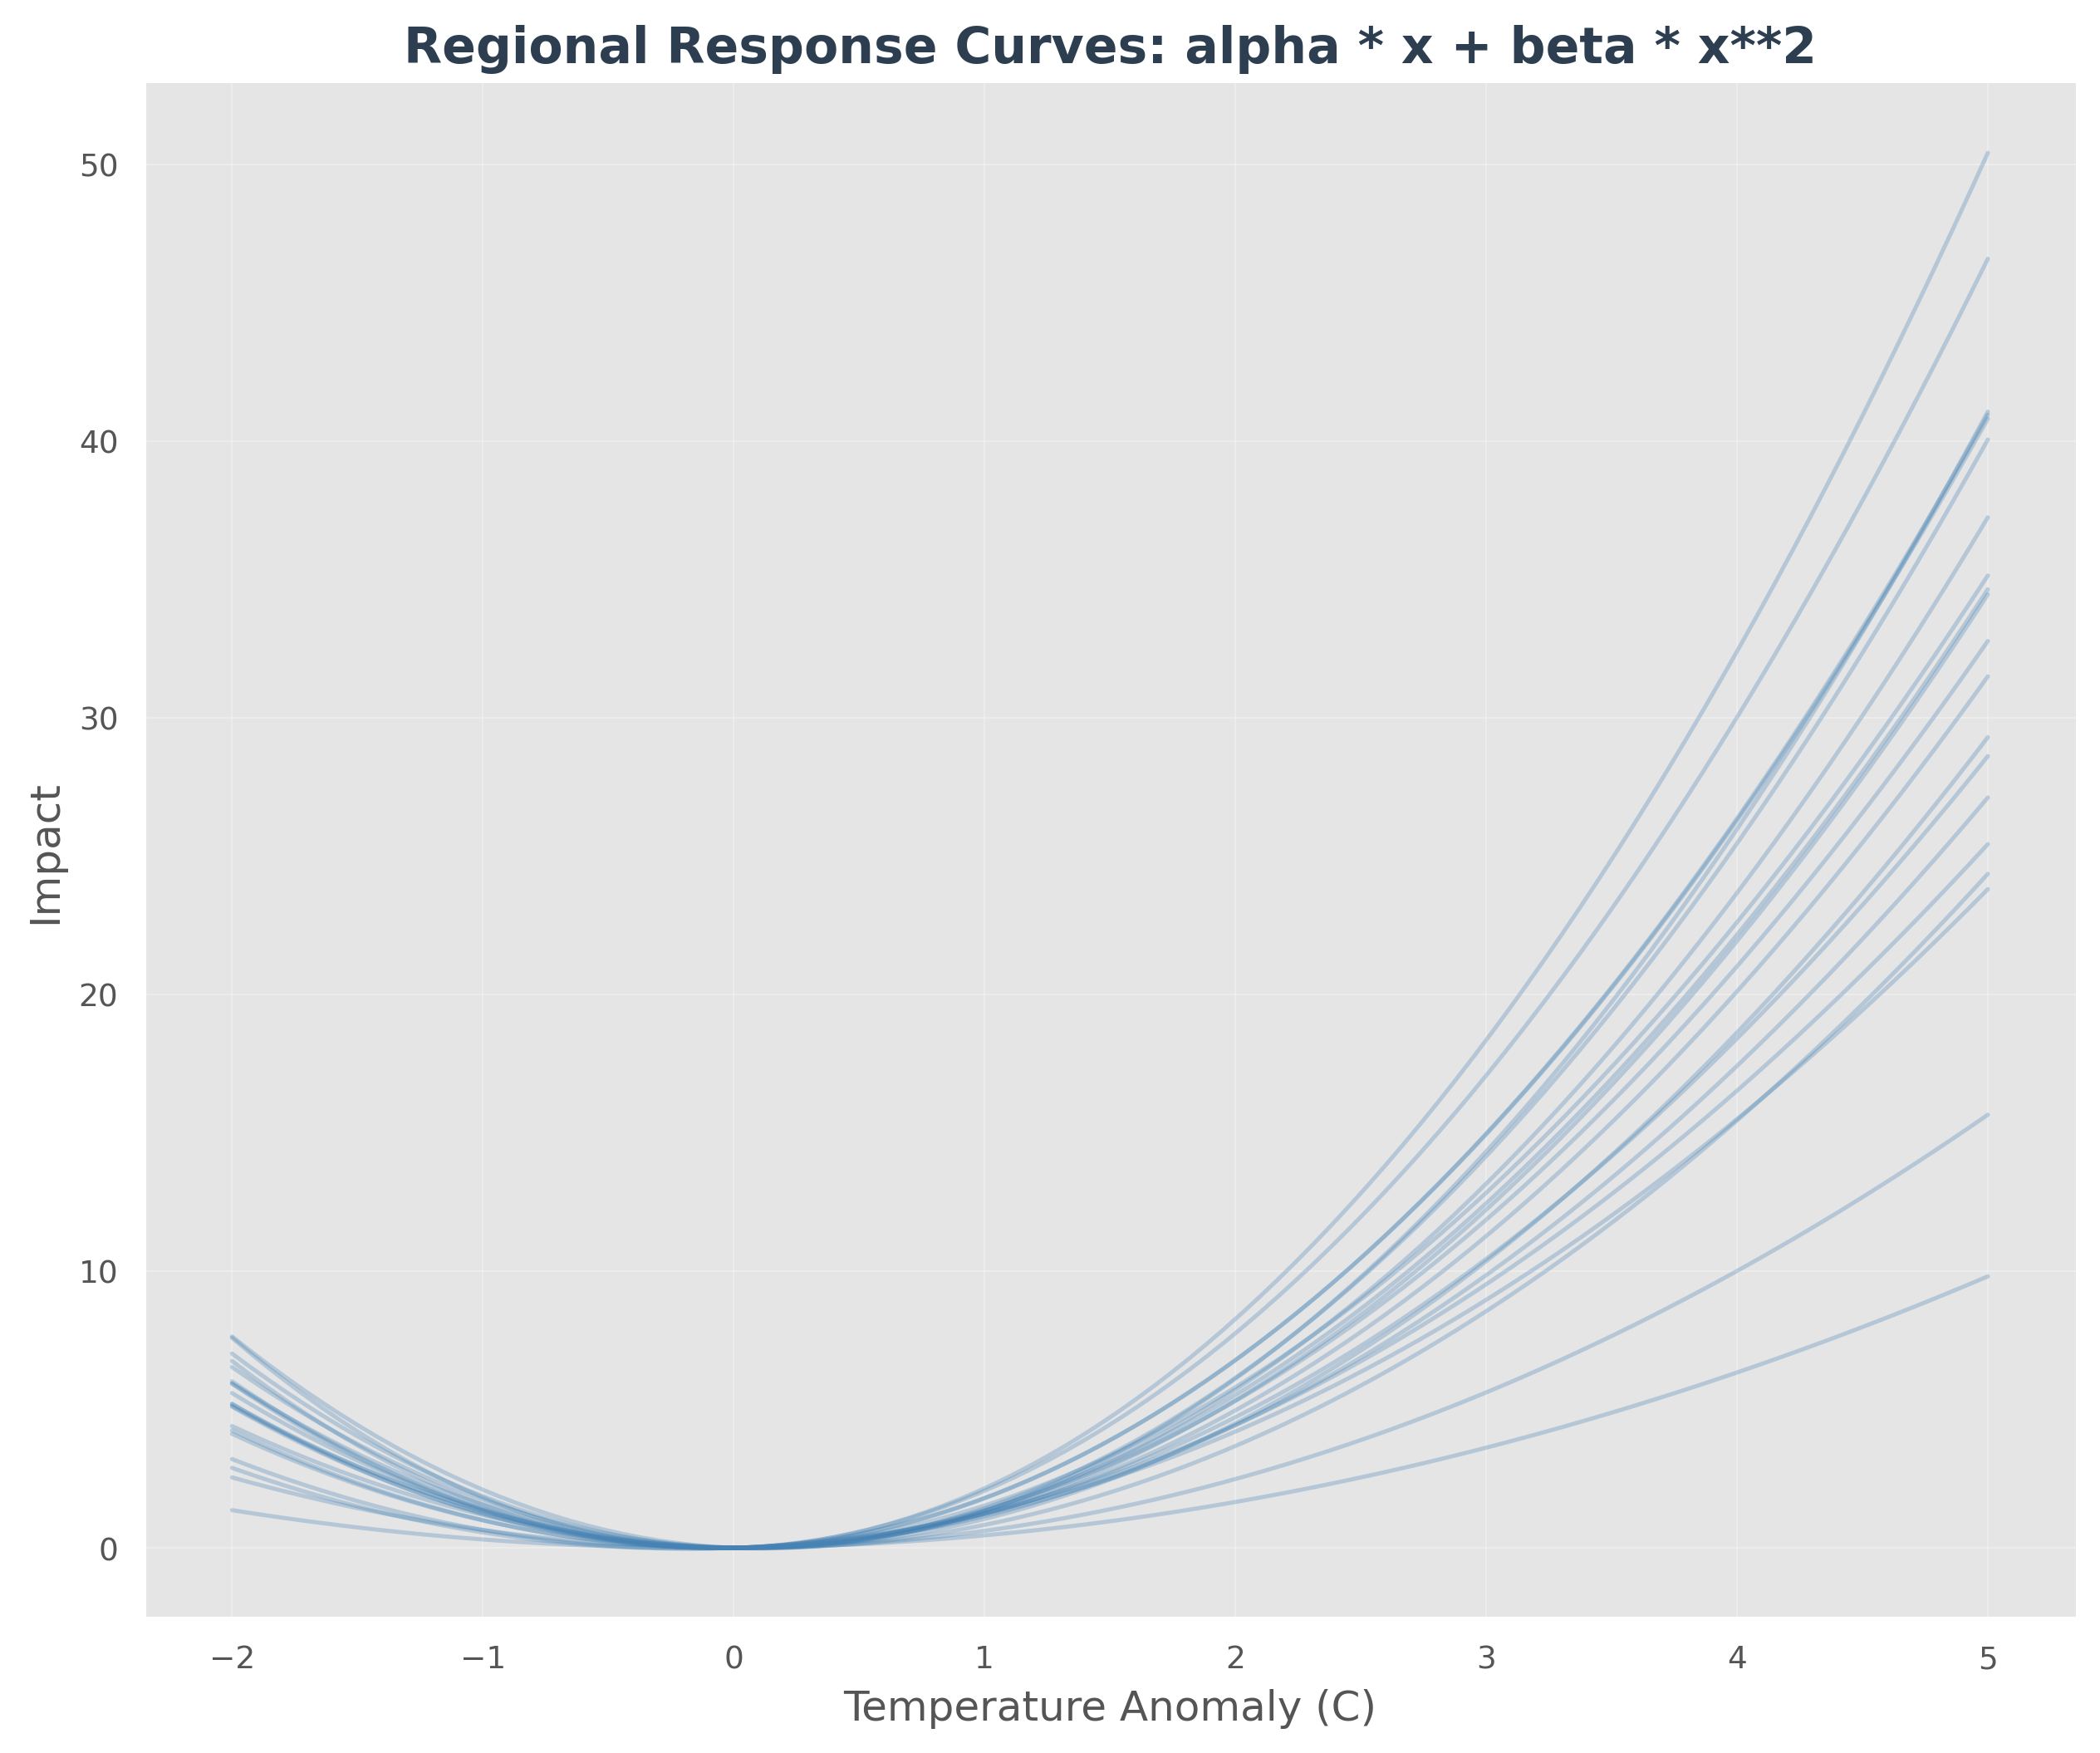

In [7]:
from IPython.display import Image, display

# Initialize the diagnostic visualizer
visualizer = DiagnosticVisualizer(diag_dir, style="scientific")

# Regional prediction curves (subset of regions)
plot_prediction_curves(df_results, config.estimation.functional_form.formula, diag_dir)
display(Image(filename=diag_dir / "regional_curves.png", width=600))

2026-01-15 16:52:27 | WARNING  | flexdamage.diagnostics.visualizer | Gamma SE not found, using estimate.
2026-01-15 16:52:28 | INFO     | flexdamage.diagnostics.visualizer | Saved gamma distribution to step_by_step_output/results/diagnostics/gamma_distribution.png


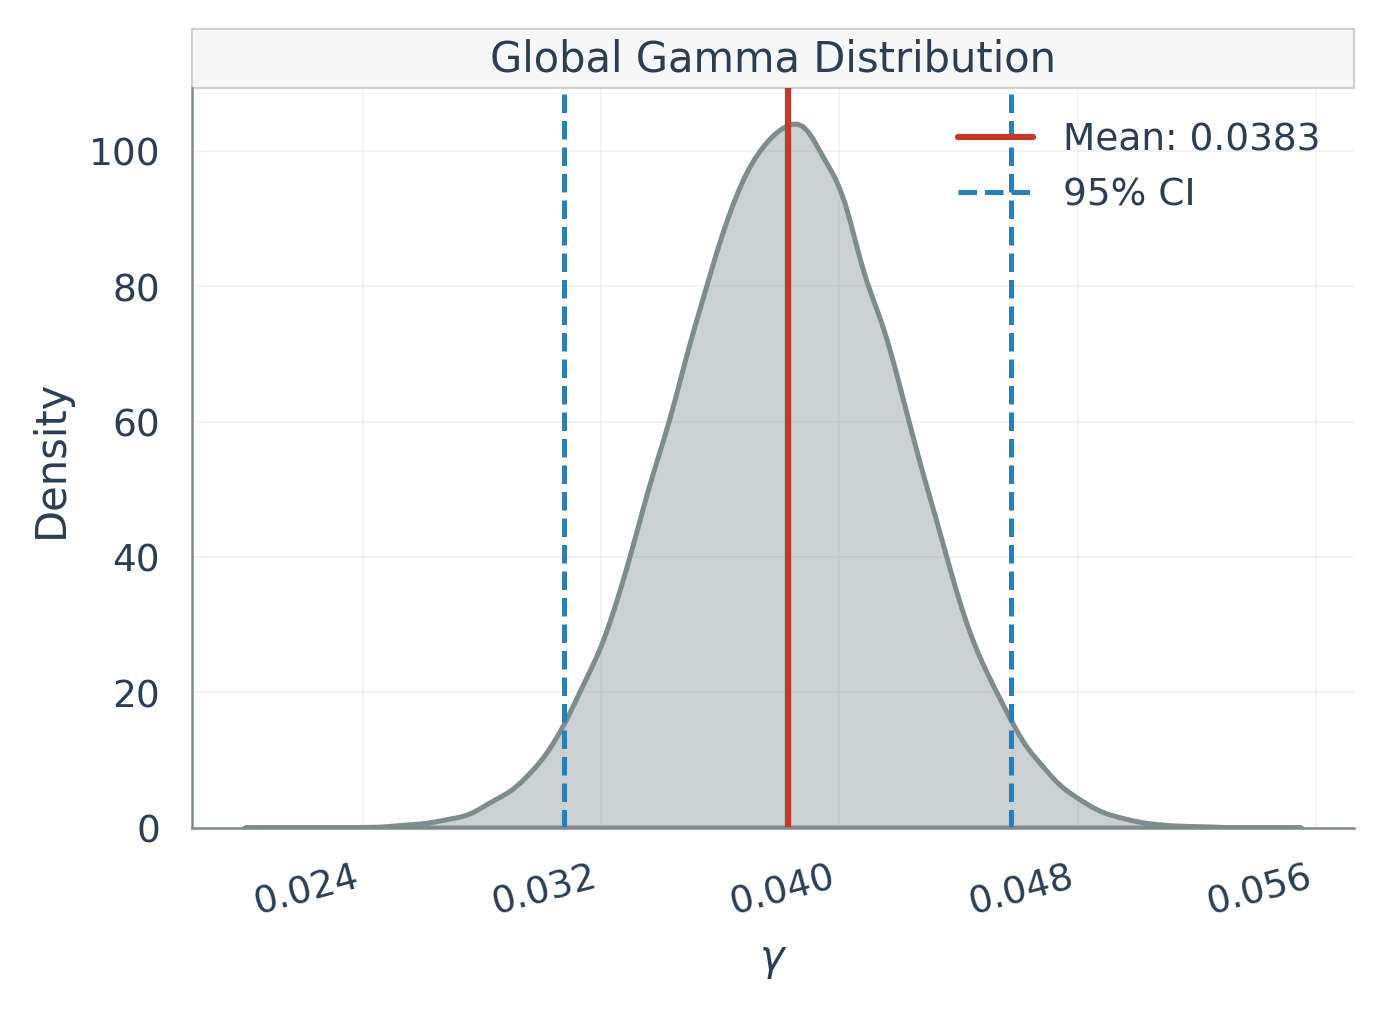

In [8]:
# Gamma distribution plot
visualizer.plot_gamma_distribution(global_results)
if (diag_dir / "gamma_distribution.png").exists():
    display(Image(filename=diag_dir / "gamma_distribution.png"))

### 6.1 Global Model Residuals

Analyze residuals over time to check for systematic bias or trends.

2026-01-15 16:52:28 | INFO     | flexdamage.diagnostics.visualizer | Saved global residuals plot to step_by_step_output/results/diagnostics/global_residuals_time.png


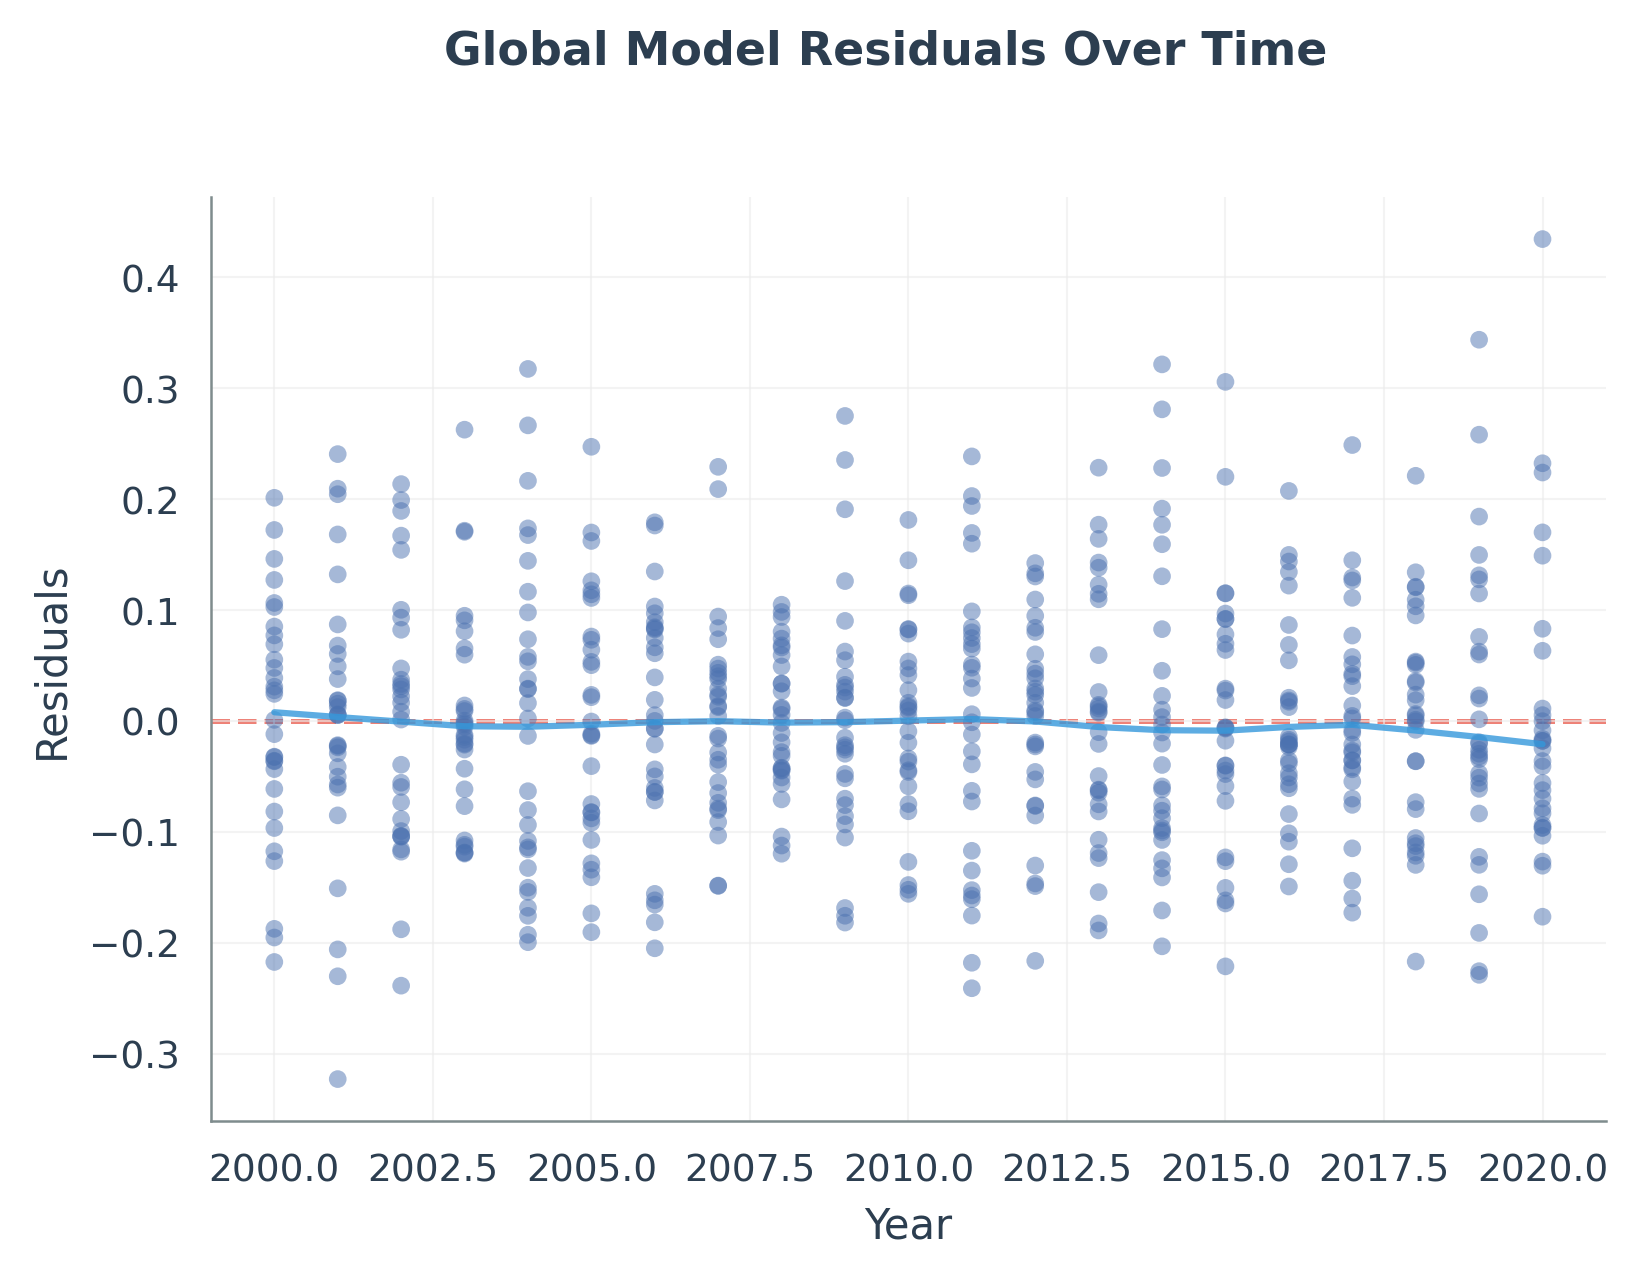

In [9]:
# Facet by SSP if available, Color by RCP if available
# Mock data might not have these, so we check or default to None
# Assuming diag_data in global_results has these columns if they were in input

visualizer.plot_global_residuals(
    global_results,
    facet_col="ssp", # Try faceting by SSP
    color_col="rcp"  # Color by RCP
)
if (diag_dir / "global_residuals_time.png").exists():
    display(Image(filename=diag_dir / "global_residuals_time.png"))

### 6.2 Fit Diagnostics

Worst offenders colored by GDP, showing fitted curve.

2026-01-15 16:52:29 | INFO     | flexdamage.diagnostics.visualizer | Saved diagnostic plot to step_by_step_output/results/diagnostics/fit_diagnostics_10.png


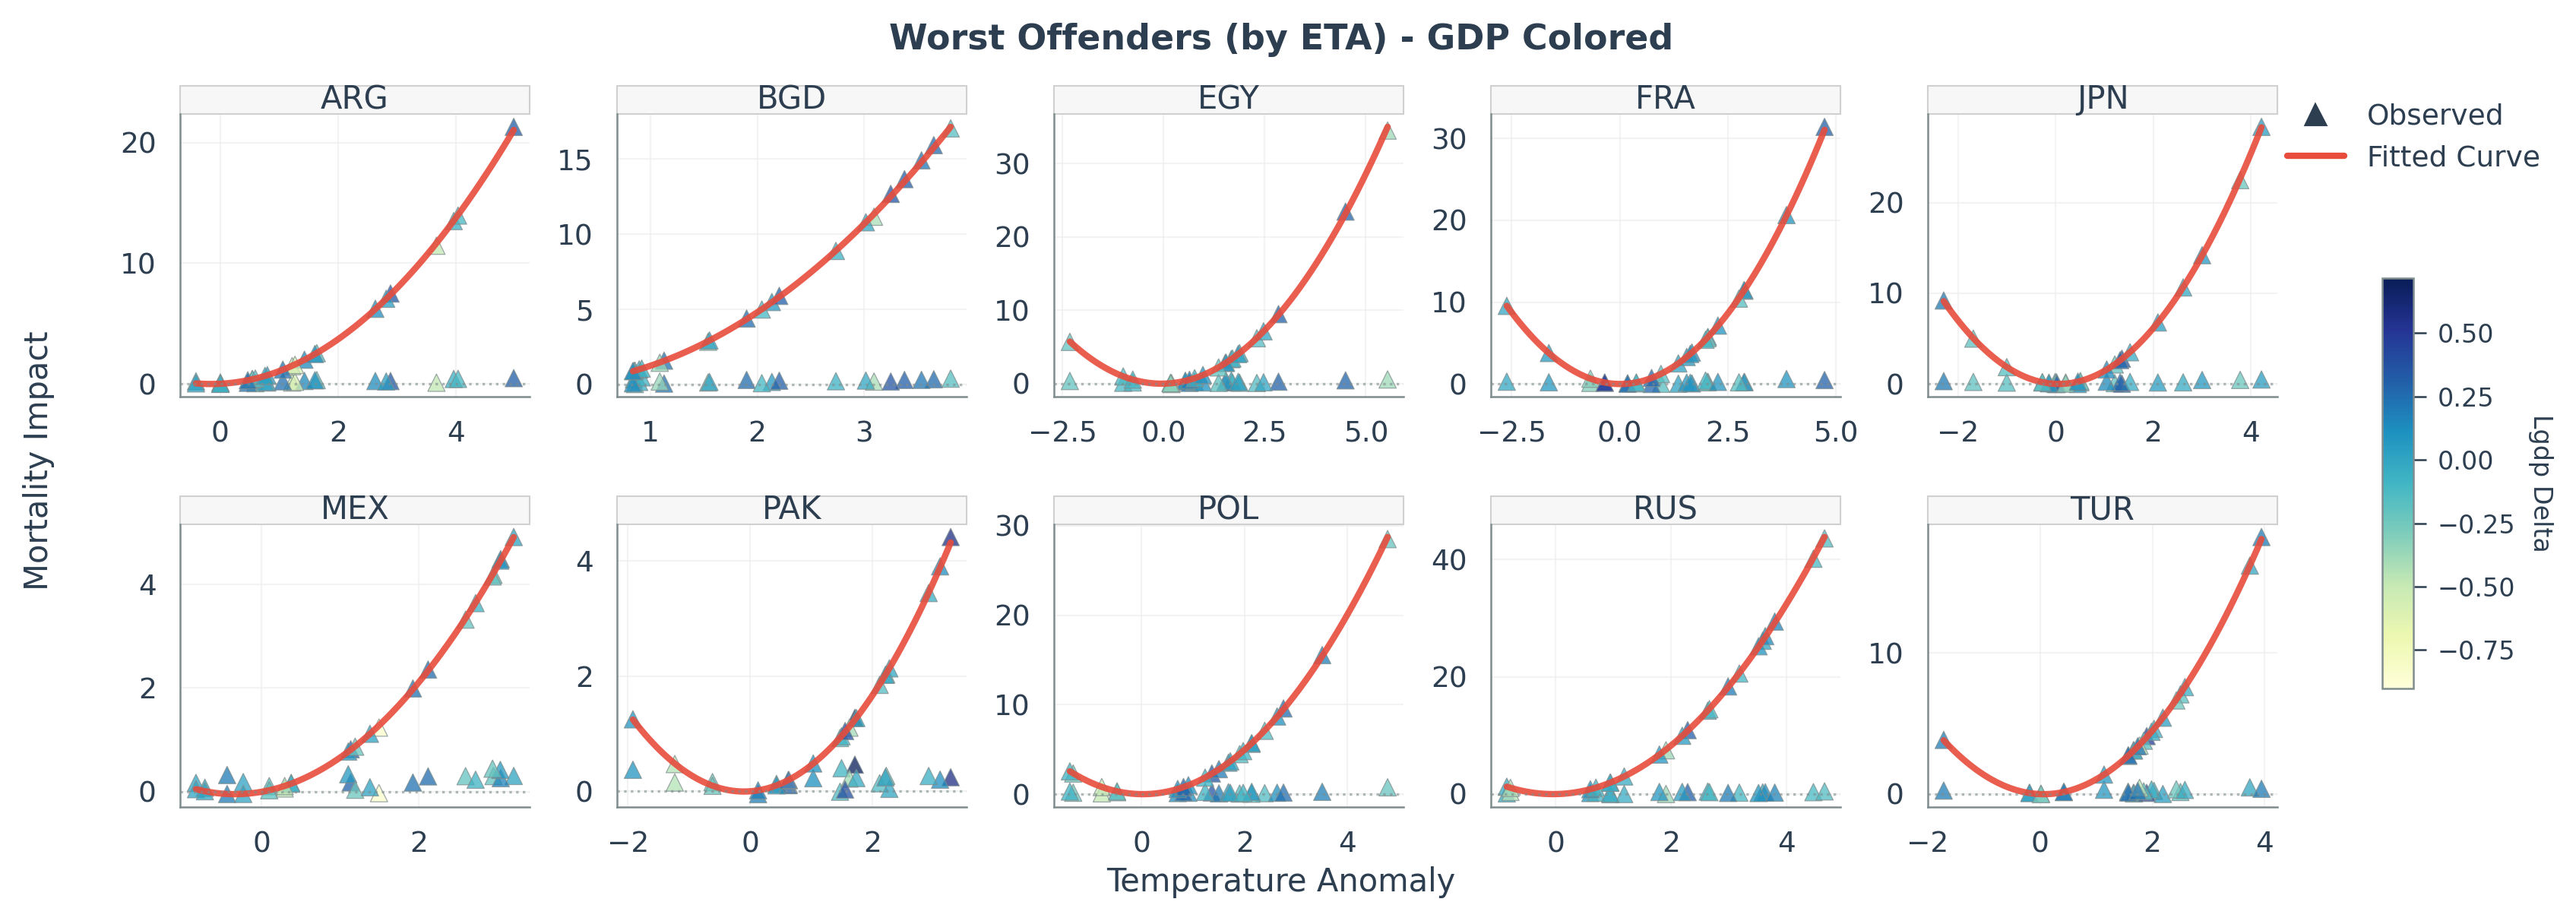

In [10]:
visualizer.plot_fit_diagnostics(
    df_results=df_results,
    df_data=df_proc,
    x_col="temperature_anomaly", 
    y_col="mortality_impact",
    gamma=gamma,
    color_col="lgdp_delta", 
    regions=visualizer.select_worst_regions(df_results, "eta", 10),
    n_cols=5,
    region_col="iso3",
    show_curve=True,
    title="Worst Offenders (by ETA) - GDP Colored"
)
display(Image(filename=diag_dir / "fit_diagnostics_10.png"))

### 6.3 Fit Diagnostics (Variant)

Worst offenders by R-squared, colored by population.

/project/cil/home_dirs/scadavidsanchez/envs/flex-damage-refactor/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


2026-01-15 16:52:30 | INFO     | flexdamage.diagnostics.visualizer | Saved diagnostic plot to step_by_step_output/results/diagnostics/fit_diagnostics_6.png


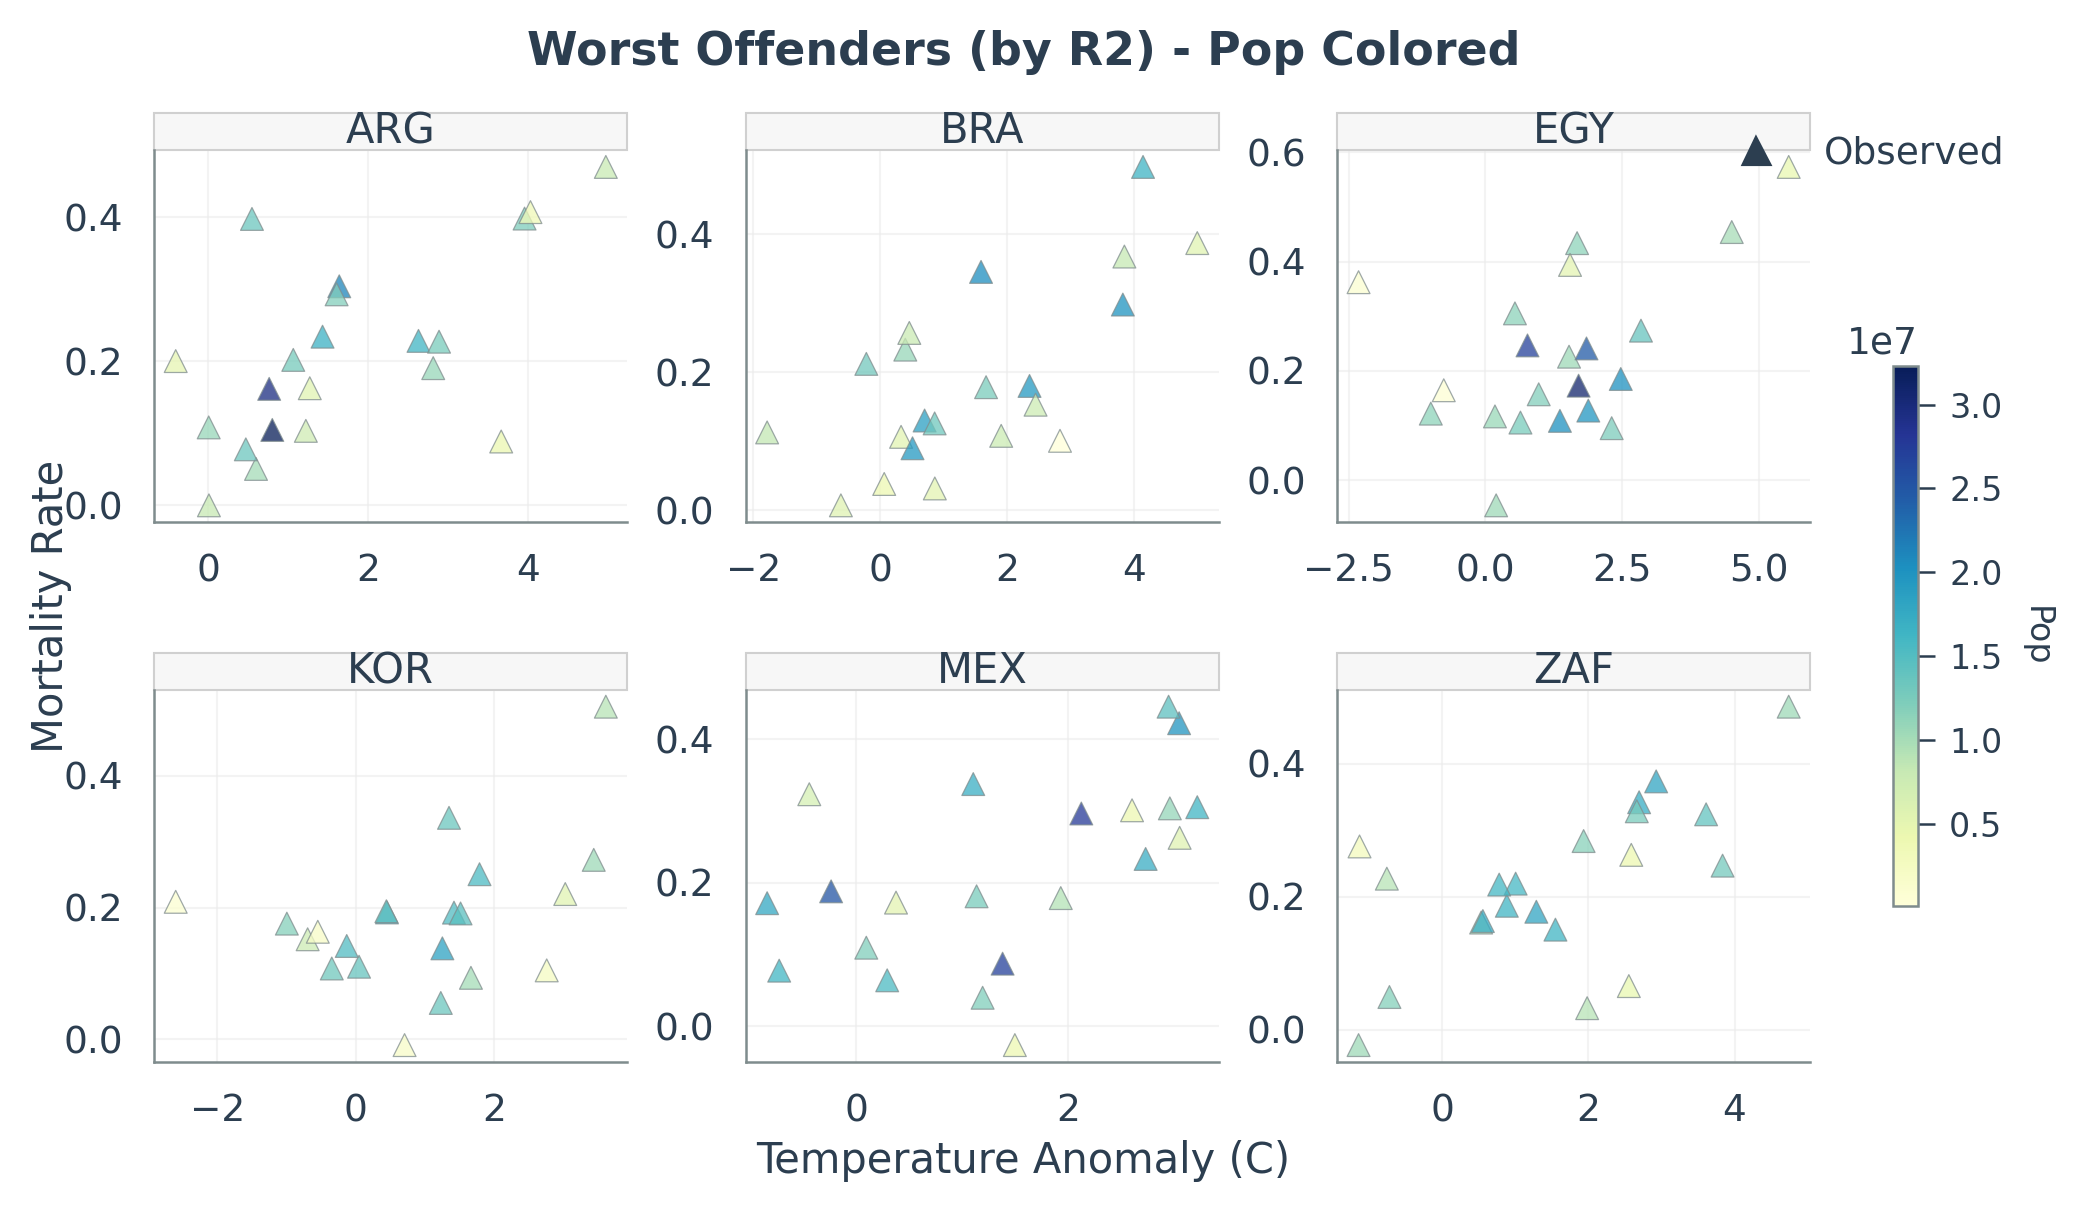

In [11]:
visualizer.plot_fit_diagnostics(
    df_results=df_results,
    df_data=df_proc,
    x_col="temperature_anomaly", 
    y_col="mortality_impact",
    gamma=gamma,
    color_col="pop", 
    regions=visualizer.select_worst_regions(df_results, "rsqr1", 6),
    n_cols=3,
    region_col="iso3",
    show_curve=False,
    xlabel="Temperature Anomaly (C)",
    ylabel="Mortality Rate",
    title="Worst Offenders (by R2) - Pop Colored"
)
display(Image(filename=diag_dir / "fit_diagnostics_6.png"))

### 6.4 Residuals Analysis

Residuals vs Temperature for worst offenders to detect model bias.

2026-01-15 16:52:31 | INFO     | flexdamage.diagnostics.visualizer | Saved residuals diagnostic to step_by_step_output/results/diagnostics/residuals_diagnostic.png


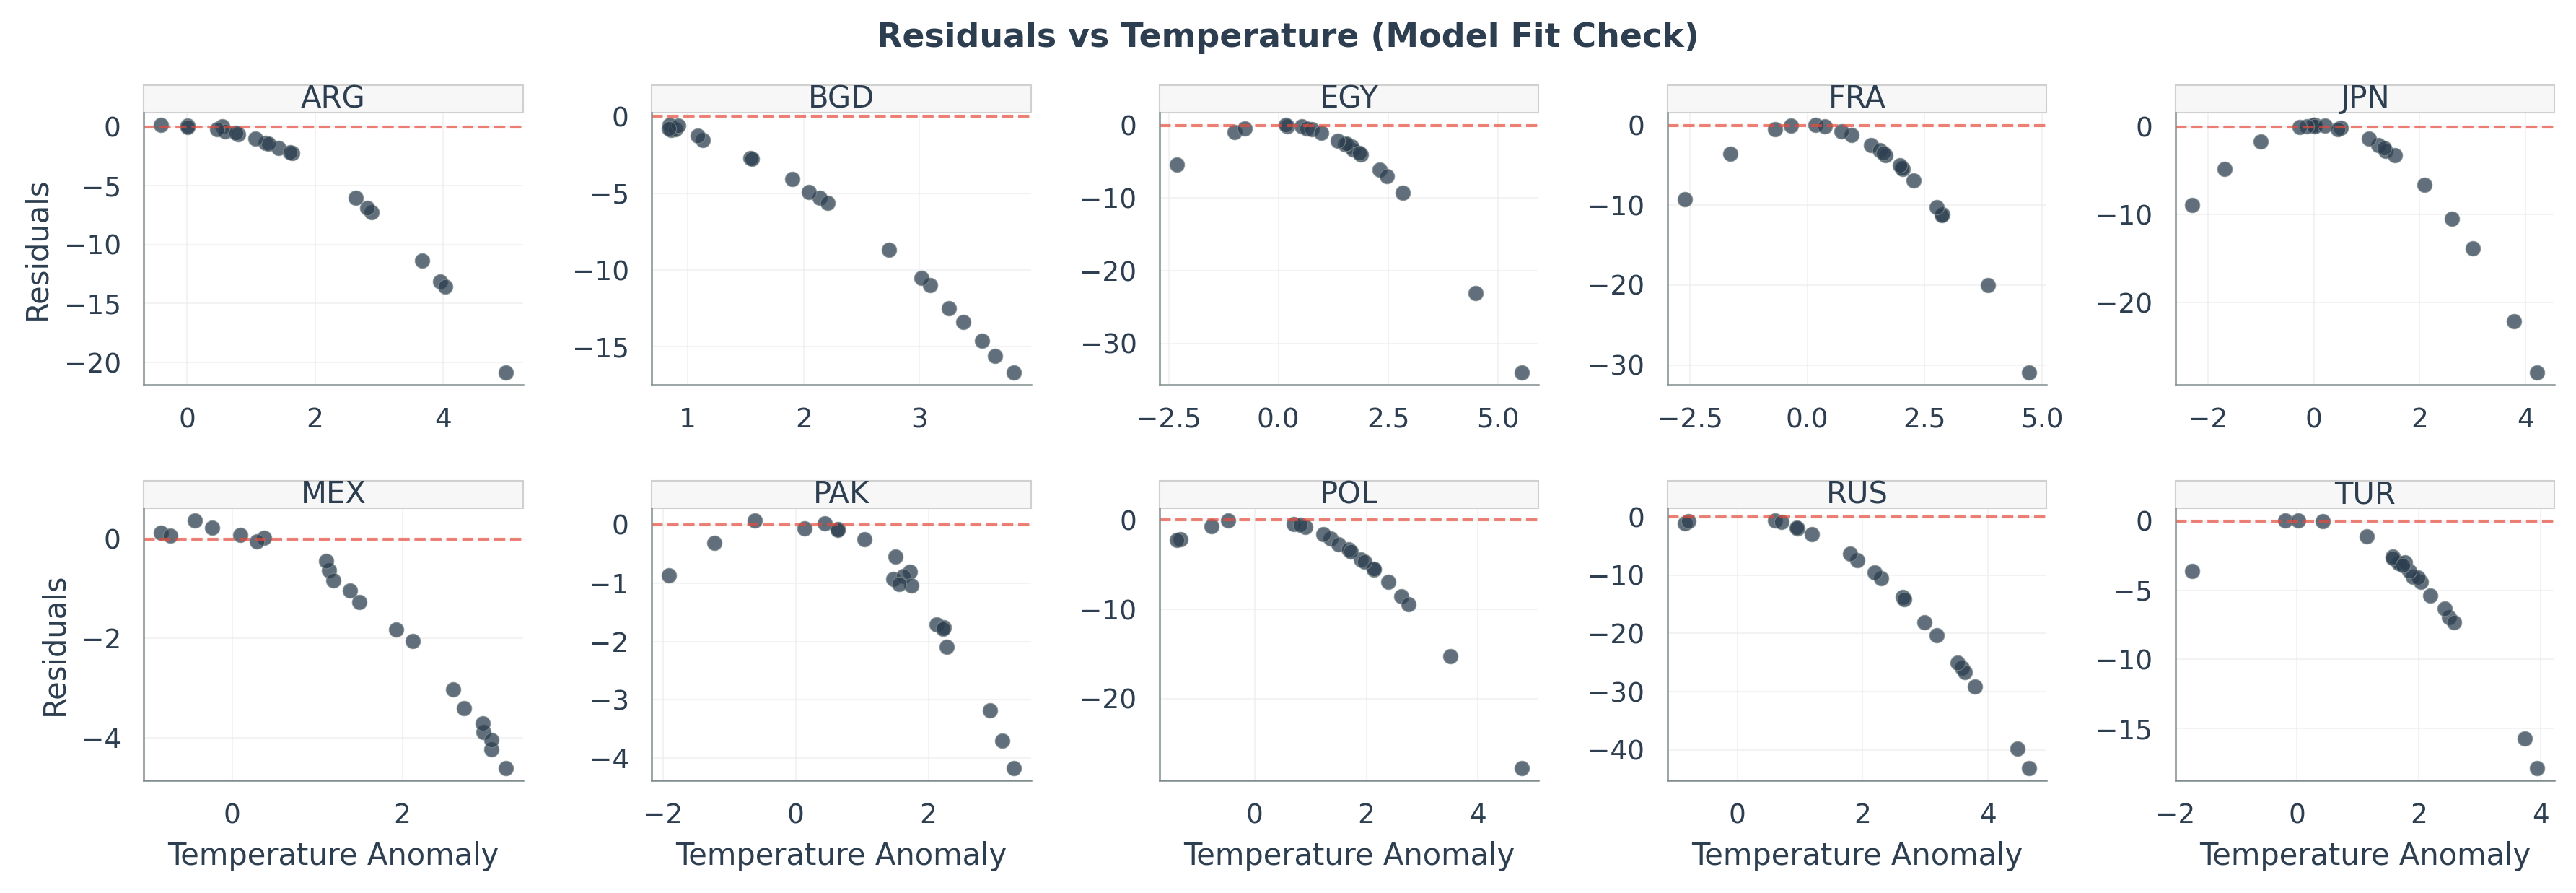

In [12]:
visualizer.plot_residuals_diagnostic(
    df_results=df_results,
    df_data=df_proc,
    x_col="temperature_anomaly",
    y_col="mortality_impact",
    gamma=gamma,
    regions=visualizer.select_worst_regions(df_results, "eta", 10),
    region_col="iso3"
)
display(Image(filename=diag_dir / "residuals_diagnostic.png"))

### 6.5 Parameter Distributions

Histograms of regional coefficients with summary statistics.

2026-01-15 16:52:32 | INFO     | flexdamage.diagnostics.visualizer | Saved parameter distributions to step_by_step_output/results/diagnostics/param_distributions.png


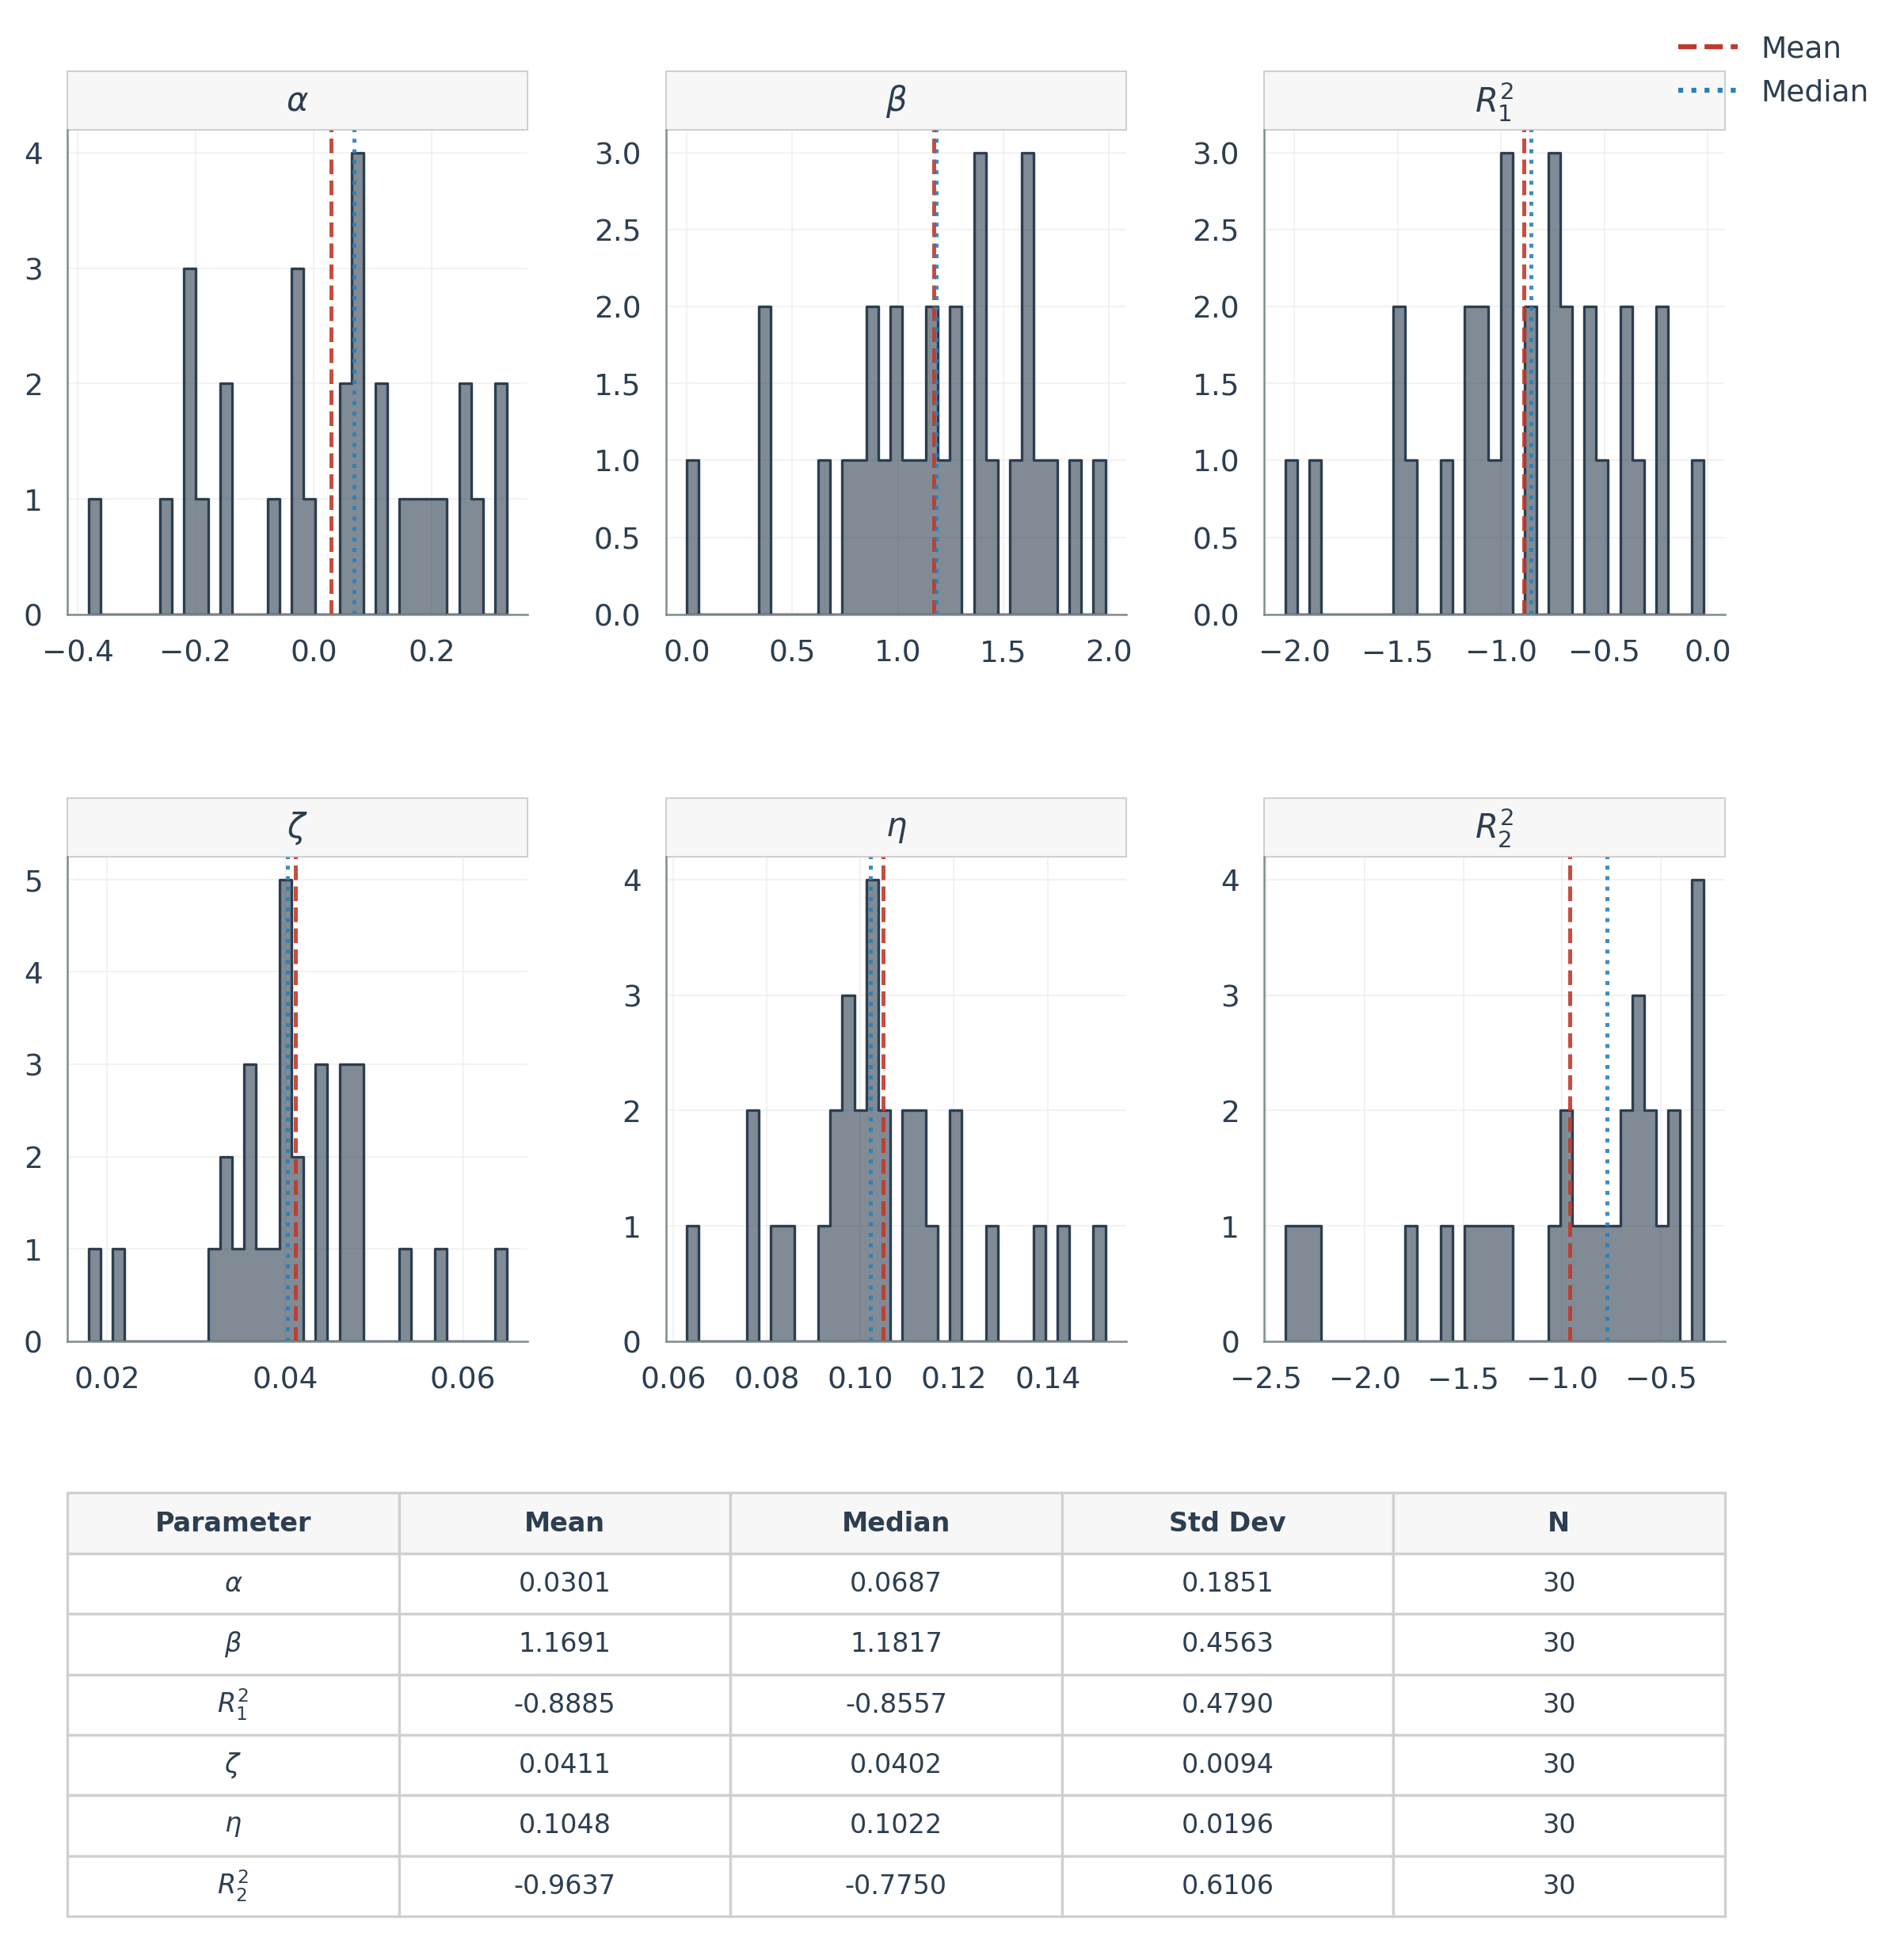

In [13]:
# Parameter distributions with stats table (show_table=True is default)
visualizer.plot_parameter_distributions(df_results, show_table=True)
if (diag_dir / "param_distributions.png").exists():
    display(Image(filename=diag_dir / "param_distributions.png"))

### 6.6 Polynomial Summary Curve

Mean damage function with IQR shading across all regions.

2026-01-15 16:52:32 | INFO     | flexdamage.diagnostics.visualizer | Saved polynomial summary to step_by_step_output/results/diagnostics/polynomial_summary.png


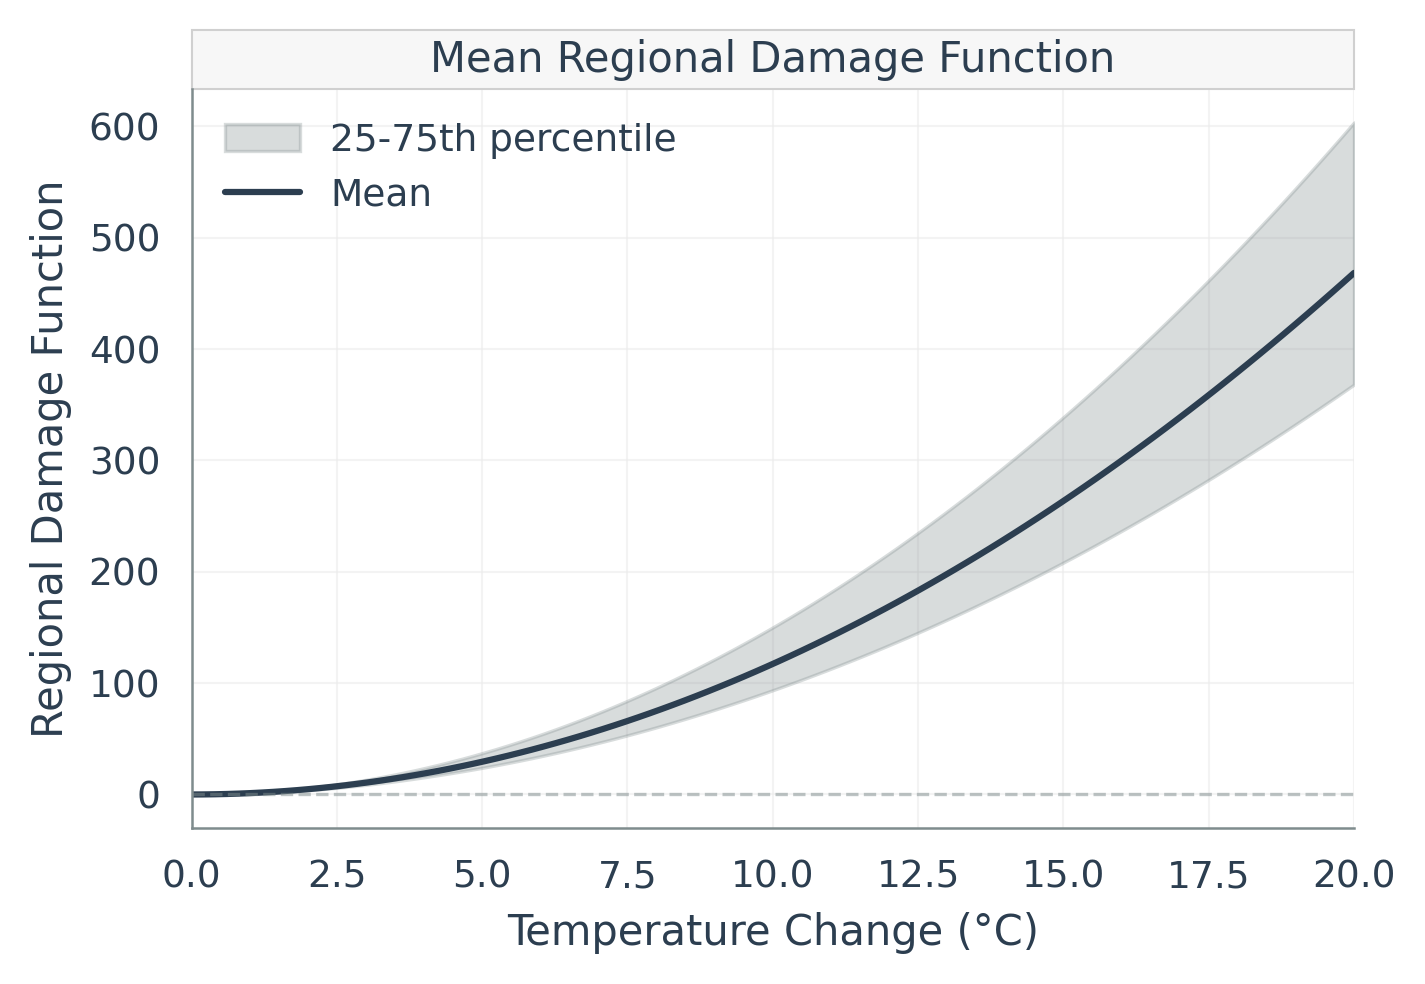

In [14]:
visualizer.plot_polynomial_summary(df_results, t_range=(0, 20))
if (diag_dir / "polynomial_summary.png").exists():
    display(Image(filename=diag_dir / "polynomial_summary.png"))

### 6.7 Crossing Zero

Temperature where damage crosses zero for convex curves.

2026-01-15 16:52:32 | INFO     | flexdamage.diagnostics.visualizer | Saved crossing_zero.png


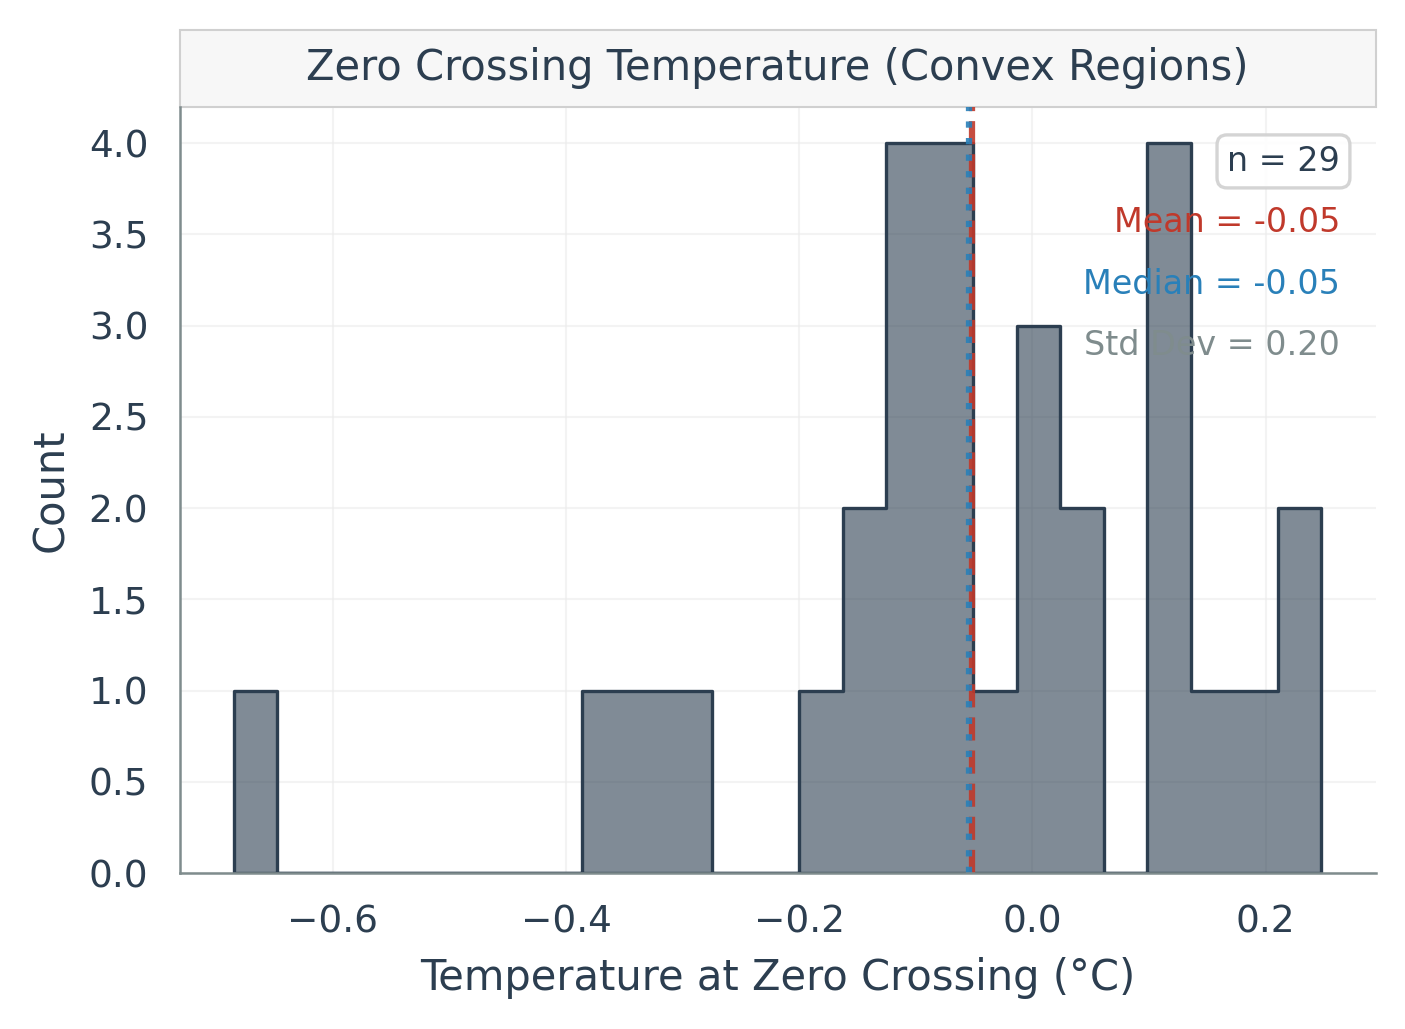

In [15]:
visualizer.plot_crossing_zero(df_results)
if (diag_dir / "crossing_zero.png").exists():
    display(Image(filename=diag_dir / "crossing_zero.png"))

### 6.8 Maximum Slope

Distribution of maximum slope in the 0-10C temperature range.

2026-01-15 16:52:32 | INFO     | flexdamage.diagnostics.visualizer | Saved maxslope_hist.png


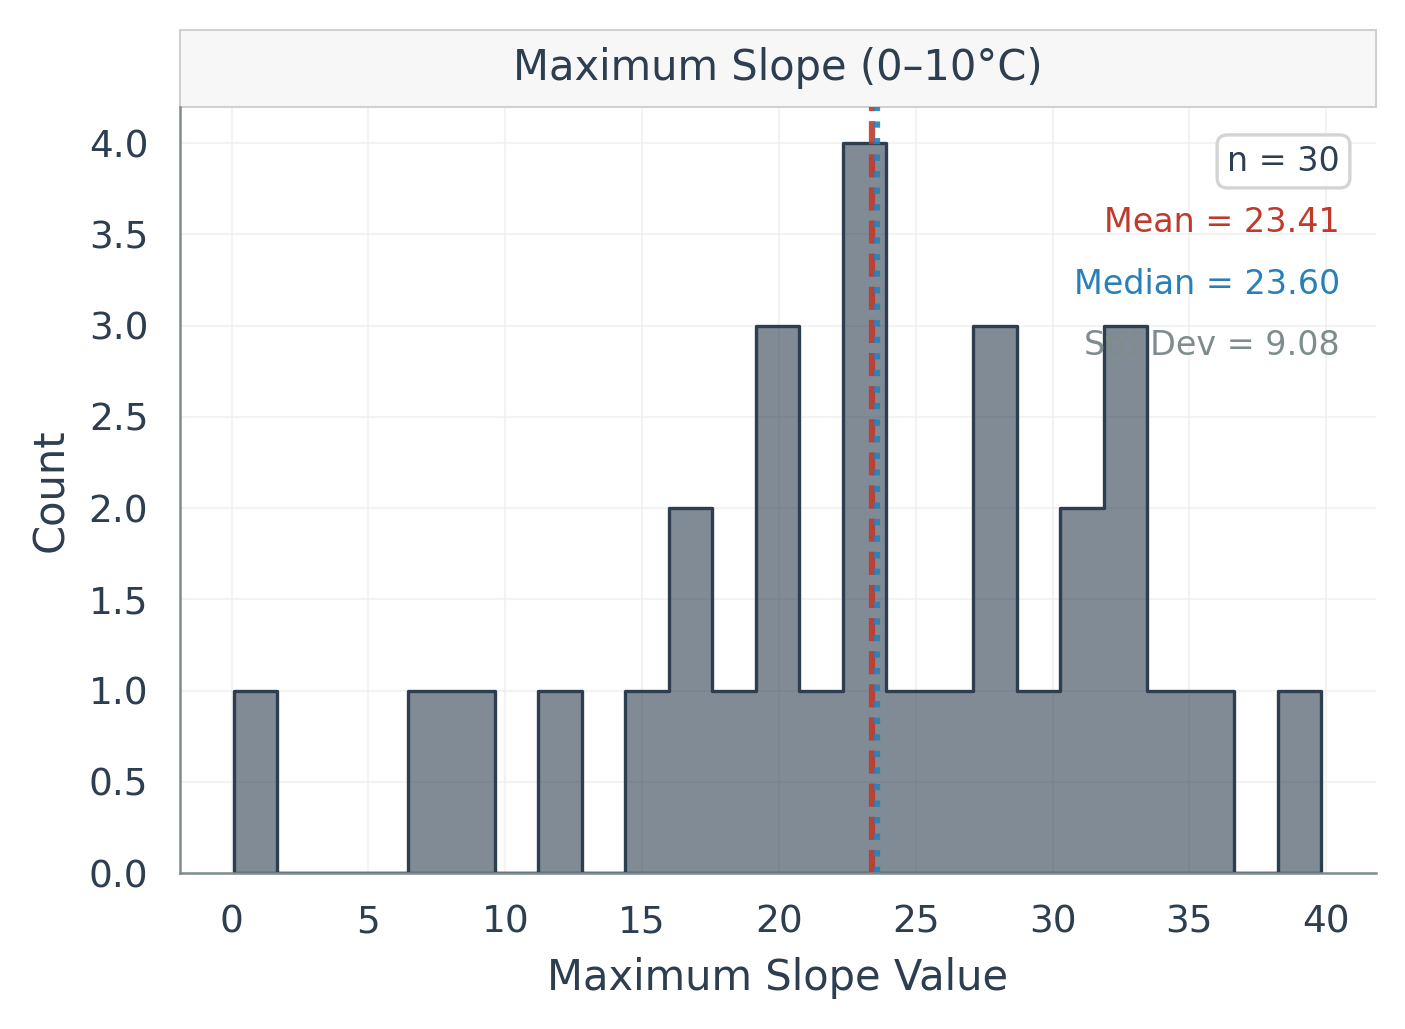

In [16]:
visualizer.plot_max_slope(df_results, t_range=(0, 10))
if (diag_dir / "maxslope_hist.png").exists():
    display(Image(filename=diag_dir / "maxslope_hist.png"))

### 6.9 Relationship Plots

Temperature-damage and economic-damage relationships with regression overlays.

2026-01-15 16:52:33 | INFO     | flexdamage.diagnostics.visualizer | Saved relationship plot to step_by_step_output/results/diagnostics/temperature_damage_relationship.png


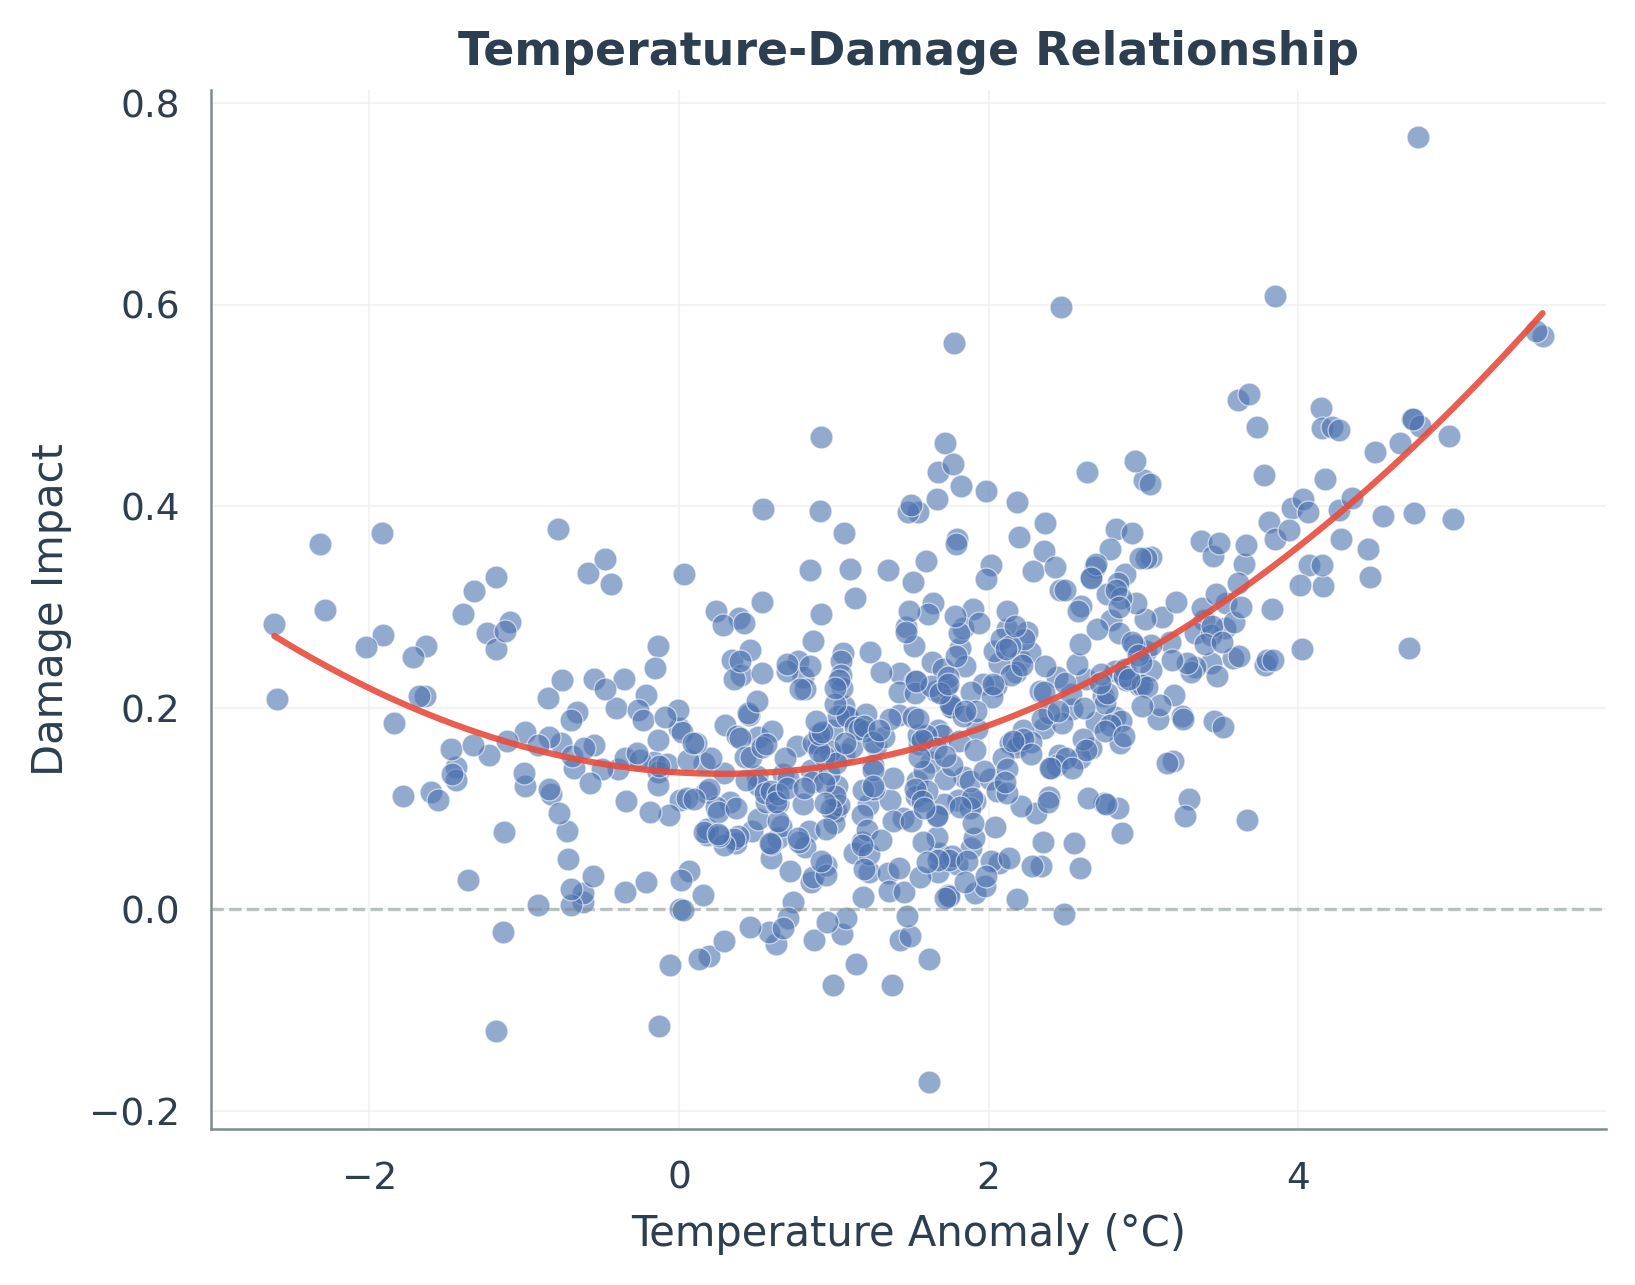

In [17]:
# Temperature-Damage relationship with polynomial regression
out_path = visualizer.plot_temperature_damage(
    df_proc,
    temp_col="temperature_anomaly",
    damage_col="mortality_impact",
    add_regression=True,
    regression_type="polynomial",
    polynomial_degree=2,
    ci=None,  # No confidence interval
)
if out_path:
    display(Image(filename=out_path))

2026-01-15 16:52:33 | INFO     | flexdamage.diagnostics.visualizer | Saved relationship plot to step_by_step_output/results/diagnostics/economic_damage_relationship.png


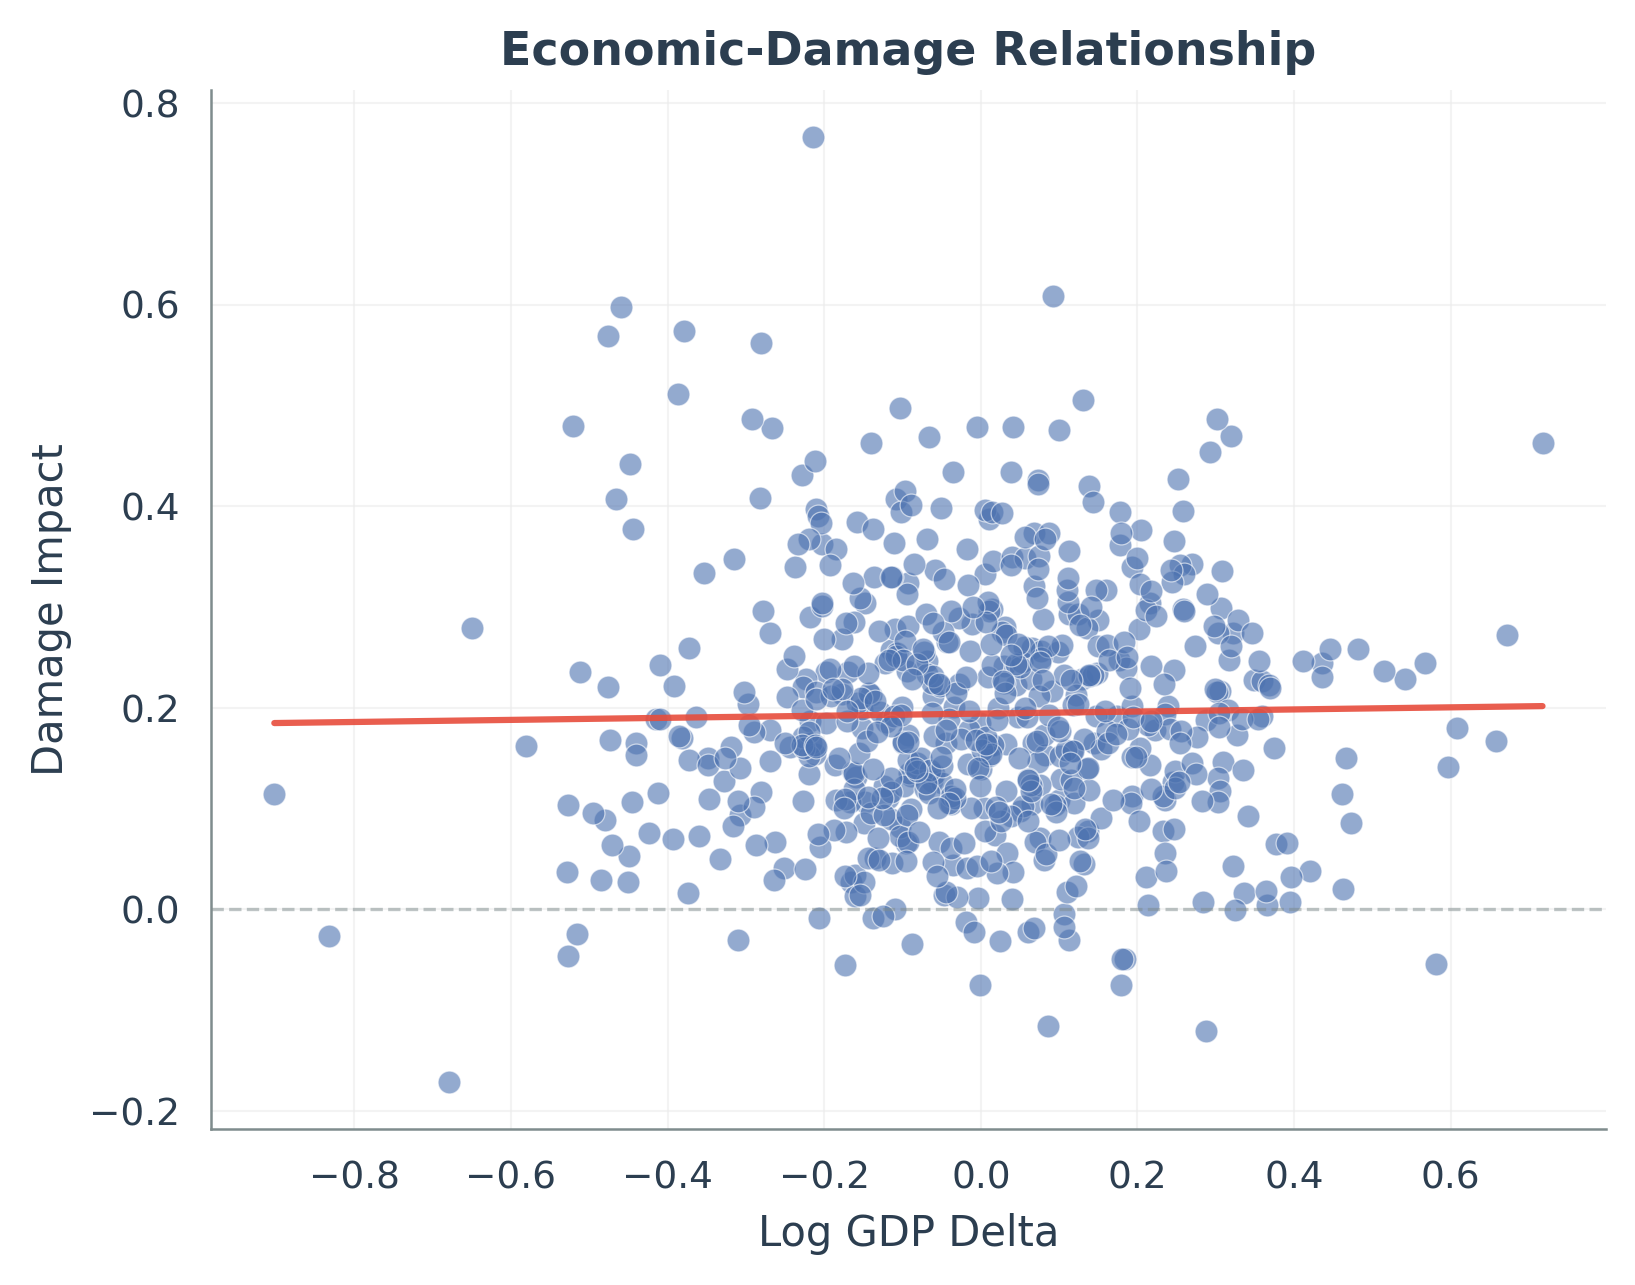

In [18]:
# Economic variable vs damage with linear regression (no CI)
out_path = visualizer.plot_economic_damage(
    df_proc,
    econ_col="lgdp_delta",
    damage_col="mortality_impact",
    add_regression=True,
    regression_type="linear",
    ci=None,  # No confidence interval
)
if out_path:
    display(Image(filename=out_path))

### 6.10 Worst Offenders with Fitted Curve

Observed data points alongside fitted polynomial curves for comparison.

2026-01-15 16:52:34 | INFO     | flexdamage.diagnostics.visualizer | Saved worst offenders to step_by_step_output/results/diagnostics/worst_offenders_detail.png


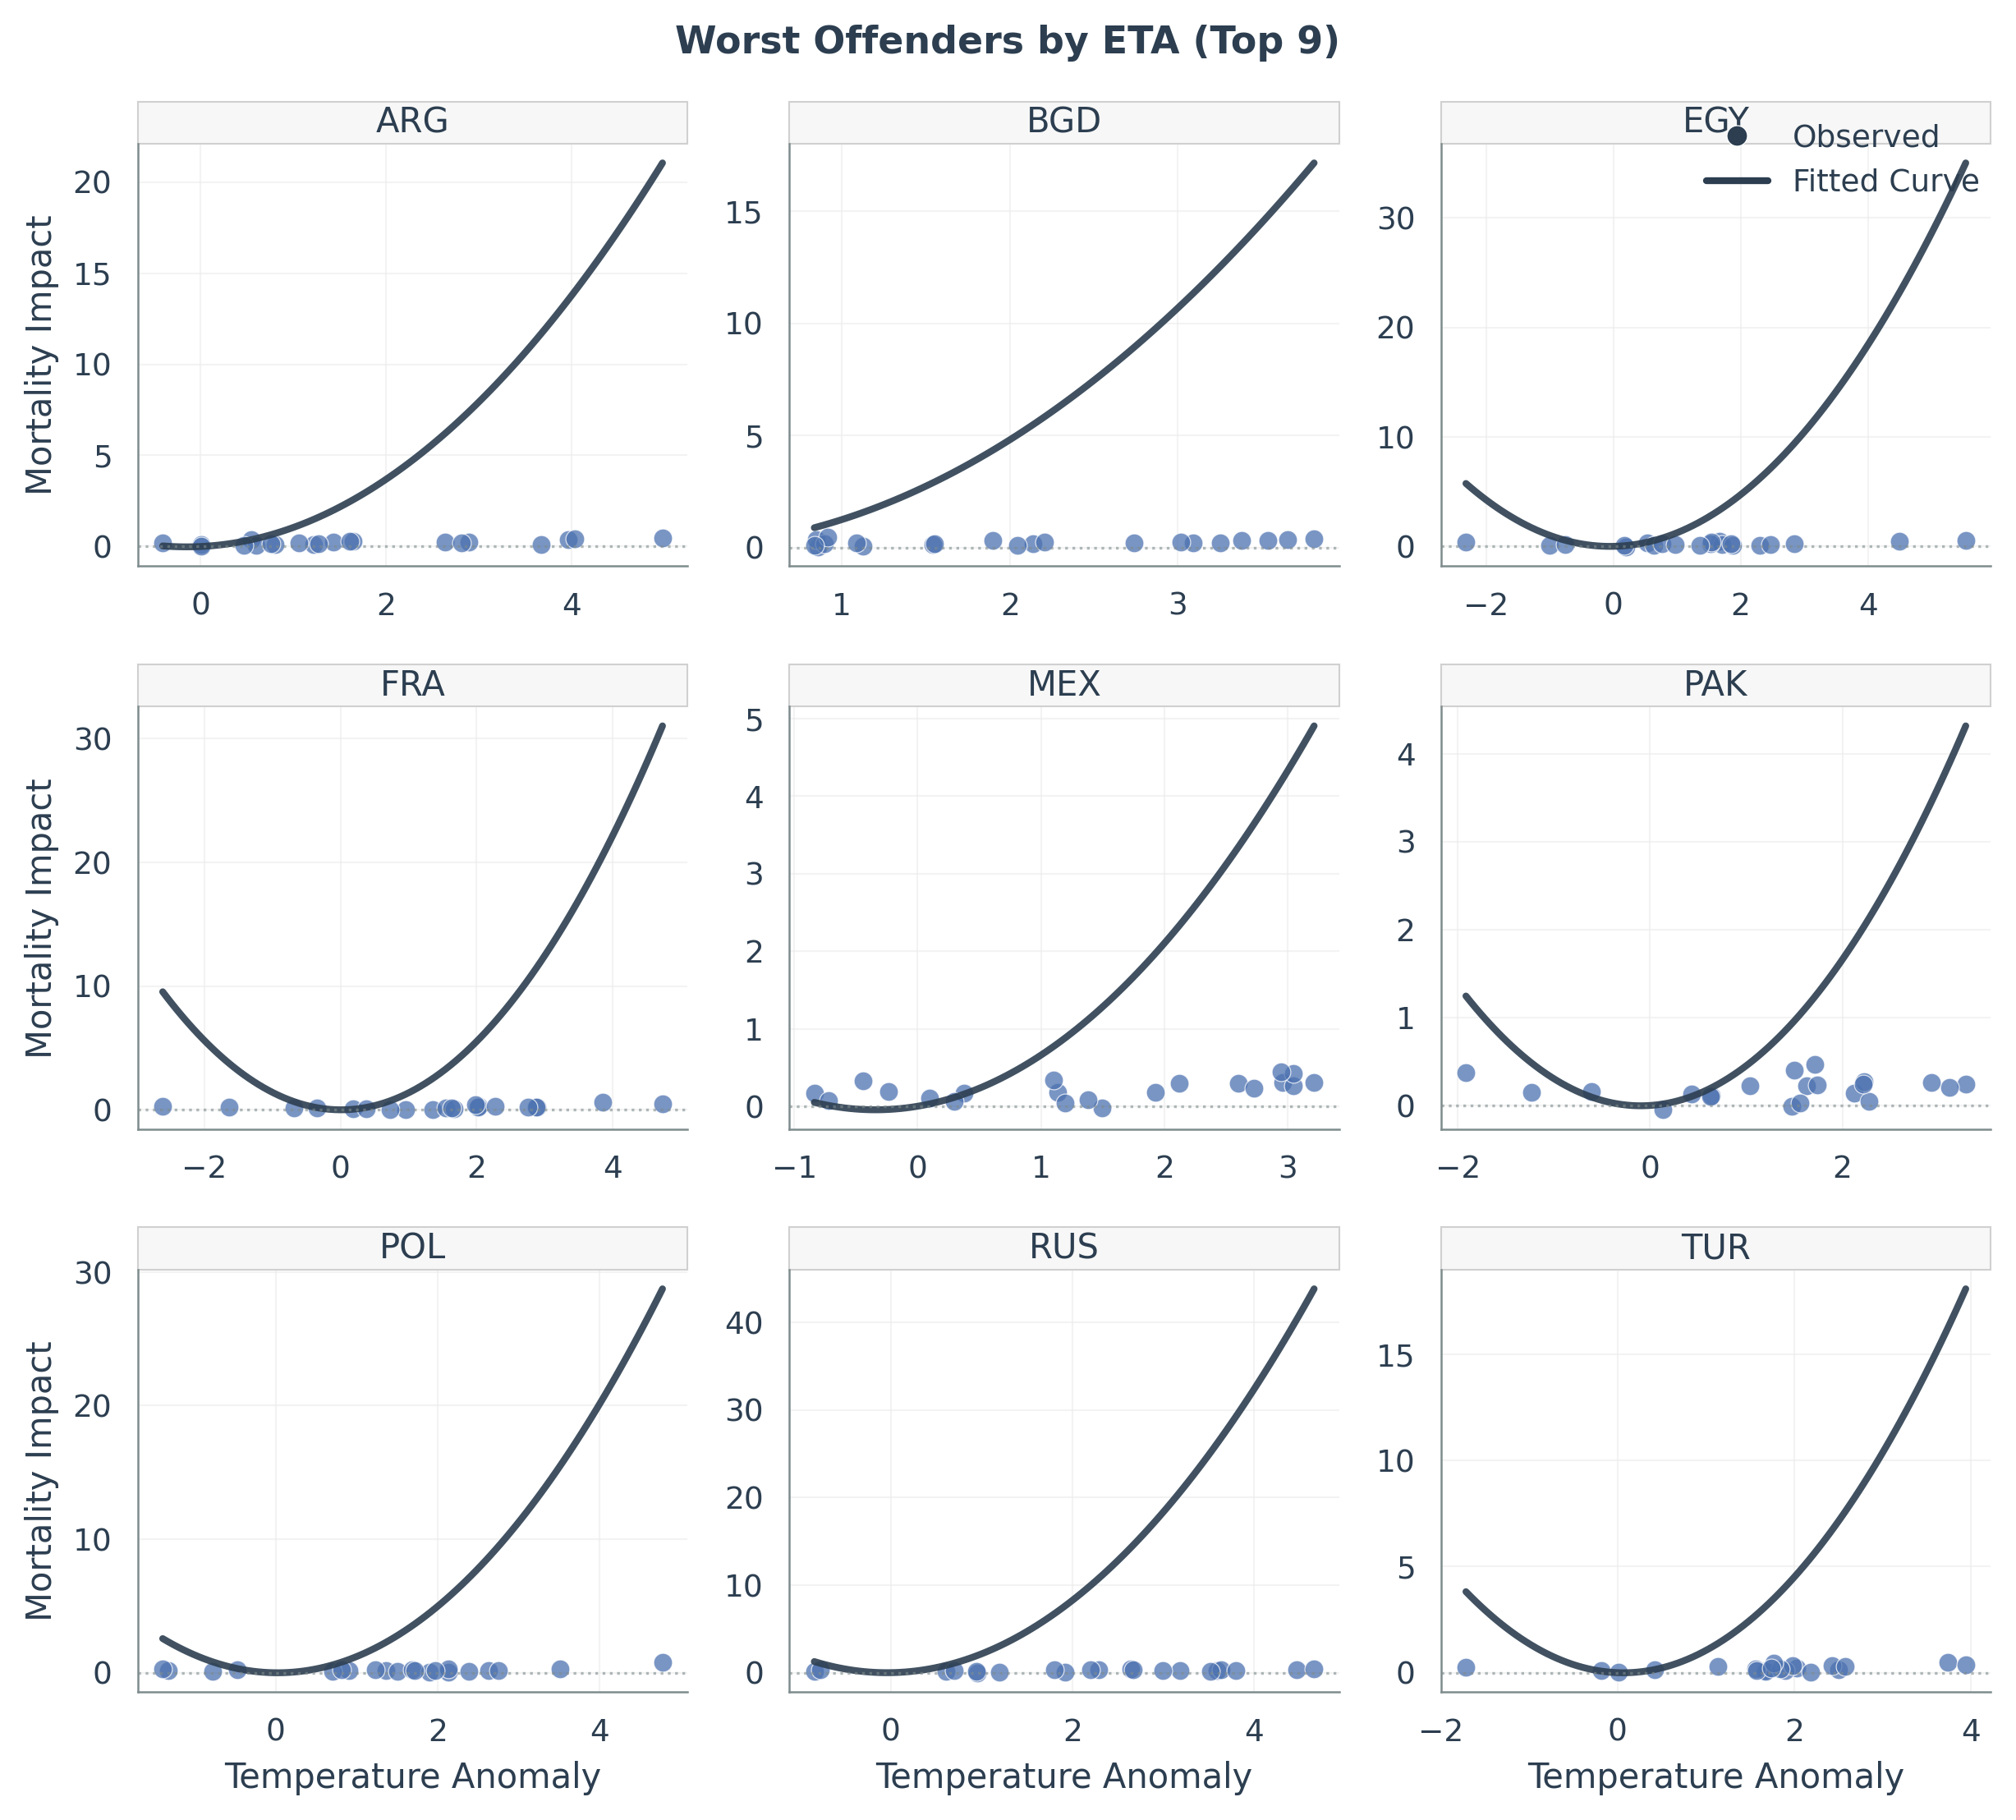

In [19]:
# Worst offenders showing both observed and fitted curve
out_path = visualizer.plot_worst_offenders(
    df_results=df_results,
    df_data=df_proc,
    x_col="temperature_anomaly",
    y_col="mortality_impact",
    criteria="eta",
    n_regions=9,
    region_col="iso3",
    show_fit=True,      # Show fitted curve
    show_observed=True  # Show observed points
)
if out_path:
    display(Image(filename=out_path))

## 7. F2 Generation & Analysis

Generate projected damage tables (`flexraw`, `rawtotal`) from the estimated parameters.

The F2 table combines:
- Regional parameters (alpha, beta)
- Temperature projections
- GDP adjustments (via gamma)

In [20]:
f2_gen = F2Generator(config, df_results)
f2_gen.generate(df_proc, f2_dir)

f2_df = pd.read_csv(f2_dir / "f2_projections.csv")
print(f"F2 Table Shape: {f2_df.shape}")
print(f"Columns: {list(f2_df.columns)}")
f2_df.head()

2026-01-15 16:52:34 | INFO     | flexdamage.core.f2_gen | Generating F2 Tables (Projections)...
2026-01-15 16:52:34 | INFO     | flexdamage.core.f2_gen | Saved F2 table to step_by_step_output/results/f2/f2_projections.csv
F2 Table Shape: (626, 22)
Columns: ['iso3', 'year', 'pop', 'lgdp_delta', 'temperature_anomaly', 'mortality_impact', '_grp', '_mortality_impact_demean', '_temperature_anomaly_demean', 'residuals', 'region', 'n', 'rsqr1', 'rsqr2', 's2', 'zeta', 'eta', 'rho', 'alpha', 'beta', 'flexraw', 'rawtotal']


iso3  year           pop  lgdp_delta  temperature_anomaly  mortality_impact  \
0  ARG  2000  2.112639e+07   -0.148306             1.638862          0.304019   
1  ARG  2001  1.091709e+07    0.099857             0.003847          0.108227   
2  ARG  2002  1.341784e+07   -0.209974             0.545660          0.397467   
3  ARG  2003  1.014882e+07   -0.134872             0.596533          0.050616   
4  ARG  2004  7.972009e+06    0.318905             4.977448          0.469634   

  _grp  _mortality_impact_demean  _temperature_anomaly_demean  residuals  ...  \
0  ARG                  0.098032                    -0.091359   0.102768  ...   
1  ARG                 -0.084876                    -1.562803  -0.023827  ...   
2  ARG                  0.160095                    -1.366567   0.213633  ...   
3  ARG                 -0.155846                    -1.120767  -0.111715  ...   
4  ARG                  0.253362                     2.879213   0.144413  ...   

      rsqr1     rsqr2        s2      zeta       eta  rho    alpha      beta  \
0 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.24718  0.800206   
1 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.24718  0.800206   
2 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.24718  0.800206   
3 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.24718  0.800206   
4 -1.464738 -0.428532  0.028246  0.047441  0.112853  0.0  0.24718  0.800206   

    flexraw  rawtotal  
0 -0.019058 -0.019058  
1  0.032662  0.032662  
2 -0.016621 -0.016621  
3 -0.018782 -0.018782  
4  0.160208  0.160208  

[5 rows x 22 columns]

### 7.1 F2 Summary Statistics

Display summary statistics of the projected damages.

In [21]:
# Summary statistics for F2 projections
print("=== F2 Projection Statistics ===\n")

# Overall statistics
print("Overall Damage Statistics:")
print(f2_df[['flexraw', 'rawtotal']].describe().round(4))

# Per-country statistics
print("\n\nDamage Statistics by Country:")
country_stats = f2_df.groupby('iso3').agg({
    'flexraw': ['mean', 'std', 'min', 'max'],
    'rawtotal': ['mean', 'std', 'min', 'max']
}).round(4)
display(country_stats)

=== F2 Projection Statistics ===

Overall Damage Statistics:
        flexraw  rawtotal
count  626.0000  626.0000
mean     0.0537    0.0537
std      0.0759    0.0759
min     -0.0562   -0.0562
25%      0.0025    0.0025
50%      0.0233    0.0233
75%      0.0808    0.0808
max      0.3622    0.3622


Damage Statistics by Country:


flexraw                         rawtotal                        
        mean     std     min     max     mean     std     min     max
iso3                                                                 
ARG   0.0450  0.0618 -0.0191  0.1831   0.0450  0.0618 -0.0191  0.1831
AUS   0.0896  0.1051 -0.0001  0.3455   0.0896  0.1051 -0.0001  0.3455
BGD   0.0611  0.0628 -0.0013  0.1783   0.0611  0.0628 -0.0013  0.1783
BRA   0.0412  0.0470 -0.0032  0.1592   0.0412  0.0470 -0.0032  0.1592
CAN   0.0430  0.0785 -0.0001  0.2738   0.0430  0.0785 -0.0001  0.2738
CHN   0.0585  0.0885 -0.0247  0.3446   0.0585  0.0885 -0.0247  0.3446
CZE   0.0485  0.0718 -0.0009  0.2719   0.0485  0.0718 -0.0009  0.2719
DEU   0.0439  0.0610 -0.0011  0.2367   0.0439  0.0610 -0.0011  0.2367
EGY   0.0499  0.0722 -0.0030  0.2489   0.0499  0.0722 -0.0030  0.2489
ESP   0.1021  0.0991 -0.0098  0.2875   0.1021  0.0991 -0.0098  0.2875
FRA   0.0532  0.0704  0.0002  0.2942   0.0532  0.0704  0.0002  0.2942
GBR   0.0468  0.0555 -0.0000  0.1777   0.0468  0.0555 -0.0000  0.1777
HUN   0.0563  0.0686 -0.0105  0.1976   0.0563  0.0686 -0.0105  0.1976
IDN   0.0778  0.1108 -0.0037  0.3622   0.0778  0.1108 -0.0037  0.3622
IND   0.0303  0.0543 -0.0301  0.1350   0.0303  0.0543 -0.0301  0.1350
IRN   0.0575  0.0715 -0.0204  0.2589   0.0575  0.0715 -0.0204  0.2589
ITA   0.0749  0.0852 -0.0018  0.2943   0.0749  0.0852 -0.0018  0.2943
JPN   0.0727  0.0752 -0.0073  0.2476   0.0727  0.0752 -0.0073  0.2476
KOR   0.0531  0.0826 -0.0086  0.2911   0.0531  0.0826 -0.0086  0.2911
MEX   0.0131  0.0488 -0.0404  0.1175   0.0131  0.0488 -0.0404  0.1175
NGA  -0.0020  0.0221 -0.0562  0.0481  -0.0020  0.0221 -0.0562  0.0481
NZL   0.0574  0.0842 -0.0005  0.3266   0.0574  0.0842 -0.0005  0.3266
PAK   0.0440  0.0774 -0.0036  0.2473   0.0440  0.0774 -0.0036  0.2473
POL   0.0517  0.0755 -0.0006  0.3411   0.0517  0.0755 -0.0006  0.3411
RUS   0.0548  0.0911 -0.0036  0.3160   0.0548  0.0911 -0.0036  0.3160
SAU   0.0713  0.0849 -0.0053  0.3336   0.0713  0.0849 -0.0053  0.3336
TUR   0.0542  0.0781 -0.0051  0.3111   0.0542  0.0781 -0.0051  0.3111
UKR   0.0523  0.0738 -0.0076  0.3180   0.0523  0.0738 -0.0076  0.3180
USA   0.0549  0.0700 -0.0071  0.2047   0.0549  0.0700 -0.0071  0.2047
ZAF   0.0552  0.0684 -0.0067  0.2380   0.0552  0.0684 -0.0067  0.2380

### 7.2 Top/Bottom Countries by Damage

Identify countries with highest and lowest projected damages.

In [22]:
# Calculate mean damage per country
mean_damages = f2_df.groupby('iso3')['flexraw'].mean().sort_values()

# Top 10 (highest damage)
print("=== Top 10 Countries by Mean Damage ===")
top_10 = mean_damages.tail(10).reset_index()
top_10.columns = ['Country', 'Mean Flexraw']
top_10 = top_10.sort_values('Mean Flexraw', ascending=False)
display(top_10)

# Bottom 10 (lowest/negative damage = benefit)
print("\n=== Bottom 10 Countries by Mean Damage ===")
bottom_10 = mean_damages.head(10).reset_index()
bottom_10.columns = ['Country', 'Mean Flexraw']
display(bottom_10)

=== Top 10 Countries by Mean Damage ===


Country  Mean Flexraw
9     ESP      0.102143
8     AUS      0.089572
7     IDN      0.077771
6     ITA      0.074889
5     JPN      0.072714
4     SAU      0.071266
3     BGD      0.061148
2     CHN      0.058521
1     IRN      0.057480
0     NZL      0.057357


=== Bottom 10 Countries by Mean Damage ===


Country  Mean Flexraw
0     NGA     -0.001968
1     MEX      0.013063
2     IND      0.030292
3     BRA      0.041239
4     CAN      0.042965
5     DEU      0.043897
6     PAK      0.044027
7     ARG      0.044979
8     GBR      0.046760
9     CZE      0.048468

## 8. Map Visualizations

Generate choropleth maps from the F2 projections using the `MapVisualizer` class.

Features:
- **Country-level maps**: Automatic geometry fetching from Natural Earth
- **Comparison maps**: Two-column diagnostic showing sign agreement
- **Statistics output**: Top/Bottom regions automatically saved to CSV

In [23]:
# Initialize the map visualizer
map_viz = MapVisualizer(
    output_dir=maps_dir,
    style="scientific"
)

print(f"Map output directory: {maps_dir}")

Map output directory: step_by_step_output/results/maps


### 8.1 Basic Country Map

Generate a choropleth map showing damage by country. Geometries are automatically fetched from Natural Earth.

In [24]:
# Aggregate F2 data to country level (mean across years)
f2_country = f2_df.groupby('iso3').agg({
    'flexraw': 'mean',
    'rawtotal': 'mean',
    'temperature_anomaly': 'mean',
    'pop': 'sum'
}).reset_index()

print(f"Aggregated to {len(f2_country)} countries")
f2_country.head()

Aggregated to 30 countries


iso3   flexraw  rawtotal  temperature_anomaly           pop
0  ARG  0.044979  0.044979             1.713052  2.660952e+08
1  AUS  0.089572  0.089572             1.571300  2.497153e+08
2  BGD  0.061148  0.061148             2.115421  3.063328e+08
3  BRA  0.041239  0.041239             1.487712  2.296572e+08
4  CAN  0.042965  0.042965             1.801647  2.634213e+08

2026-01-15 16:52:36 | INFO     | flexdamage.diagnostics.maps | Fetching country geometries from Natural Earth...
2026-01-15 16:52:36 | INFO     | flexdamage.diagnostics.maps | Fetching from Natural Earth CDN...
2026-01-15 16:52:39 | INFO     | flexdamage.diagnostics.maps | Loaded 171 country geometries
2026-01-15 16:52:39 | INFO     | flexdamage.diagnostics.maps | Saved map to step_by_step_output/results/maps/country_damage_map.png
2026-01-15 16:52:39 | INFO     | flexdamage.diagnostics.maps | Saved stats to step_by_step_output/results/maps/country_damage_map_stats.csv


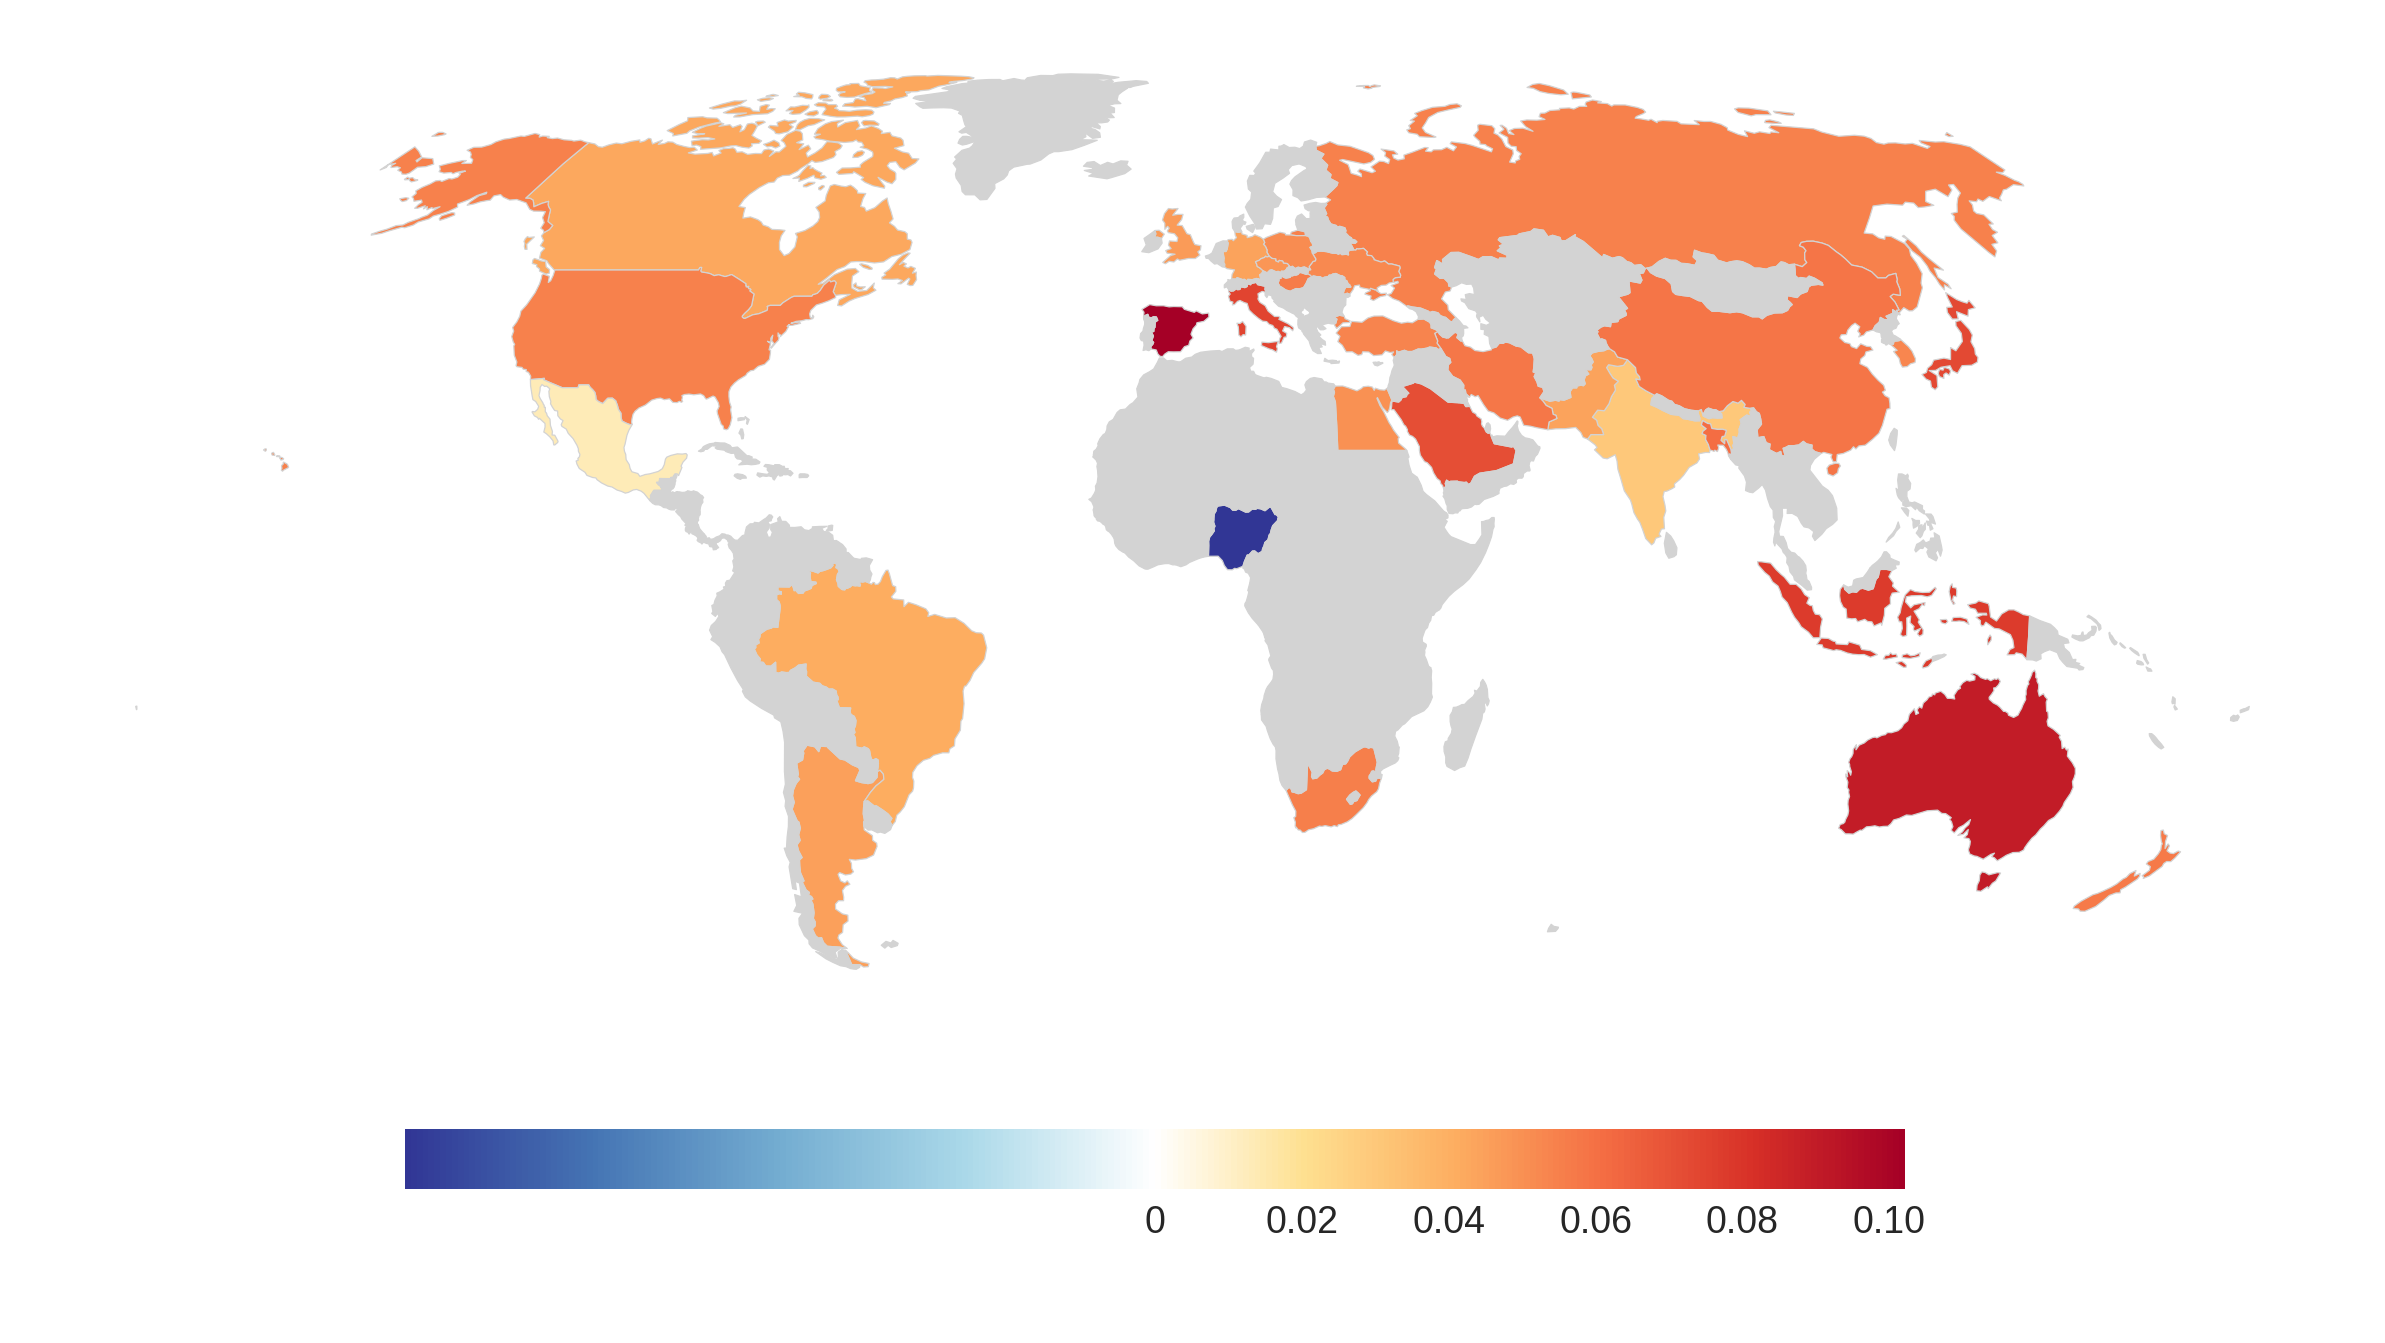

In [25]:
# Generate country-level choropleth map
out_path = map_viz.plot_country_map(
    data=f2_country,
    value_col="flexraw",
    geo_id_col="iso3",
    title="Mean Damage by Country",
    units="damage units",
    cmap_style="degree_days",
    filename="country_damage_map.png"
)

if out_path:
    display(Image(filename=out_path))

### 8.2 Comparison Map

Compare `flexraw` vs `rawtotal` to assess sign agreement and magnitude differences.

Colors:
- **Green**: Both values have the same sign (agreement)
- **Red**: Values have different signs (disagreement)
- **Intensity**: Magnitude of difference

2026-01-15 16:52:39 | INFO     | flexdamage.diagnostics.maps | Saved comparison map to step_by_step_output/results/maps/comparison_map.png
2026-01-15 16:52:39 | INFO     | flexdamage.diagnostics.maps | Saved comparison stats to step_by_step_output/results/maps/comparison_map_stats.csv


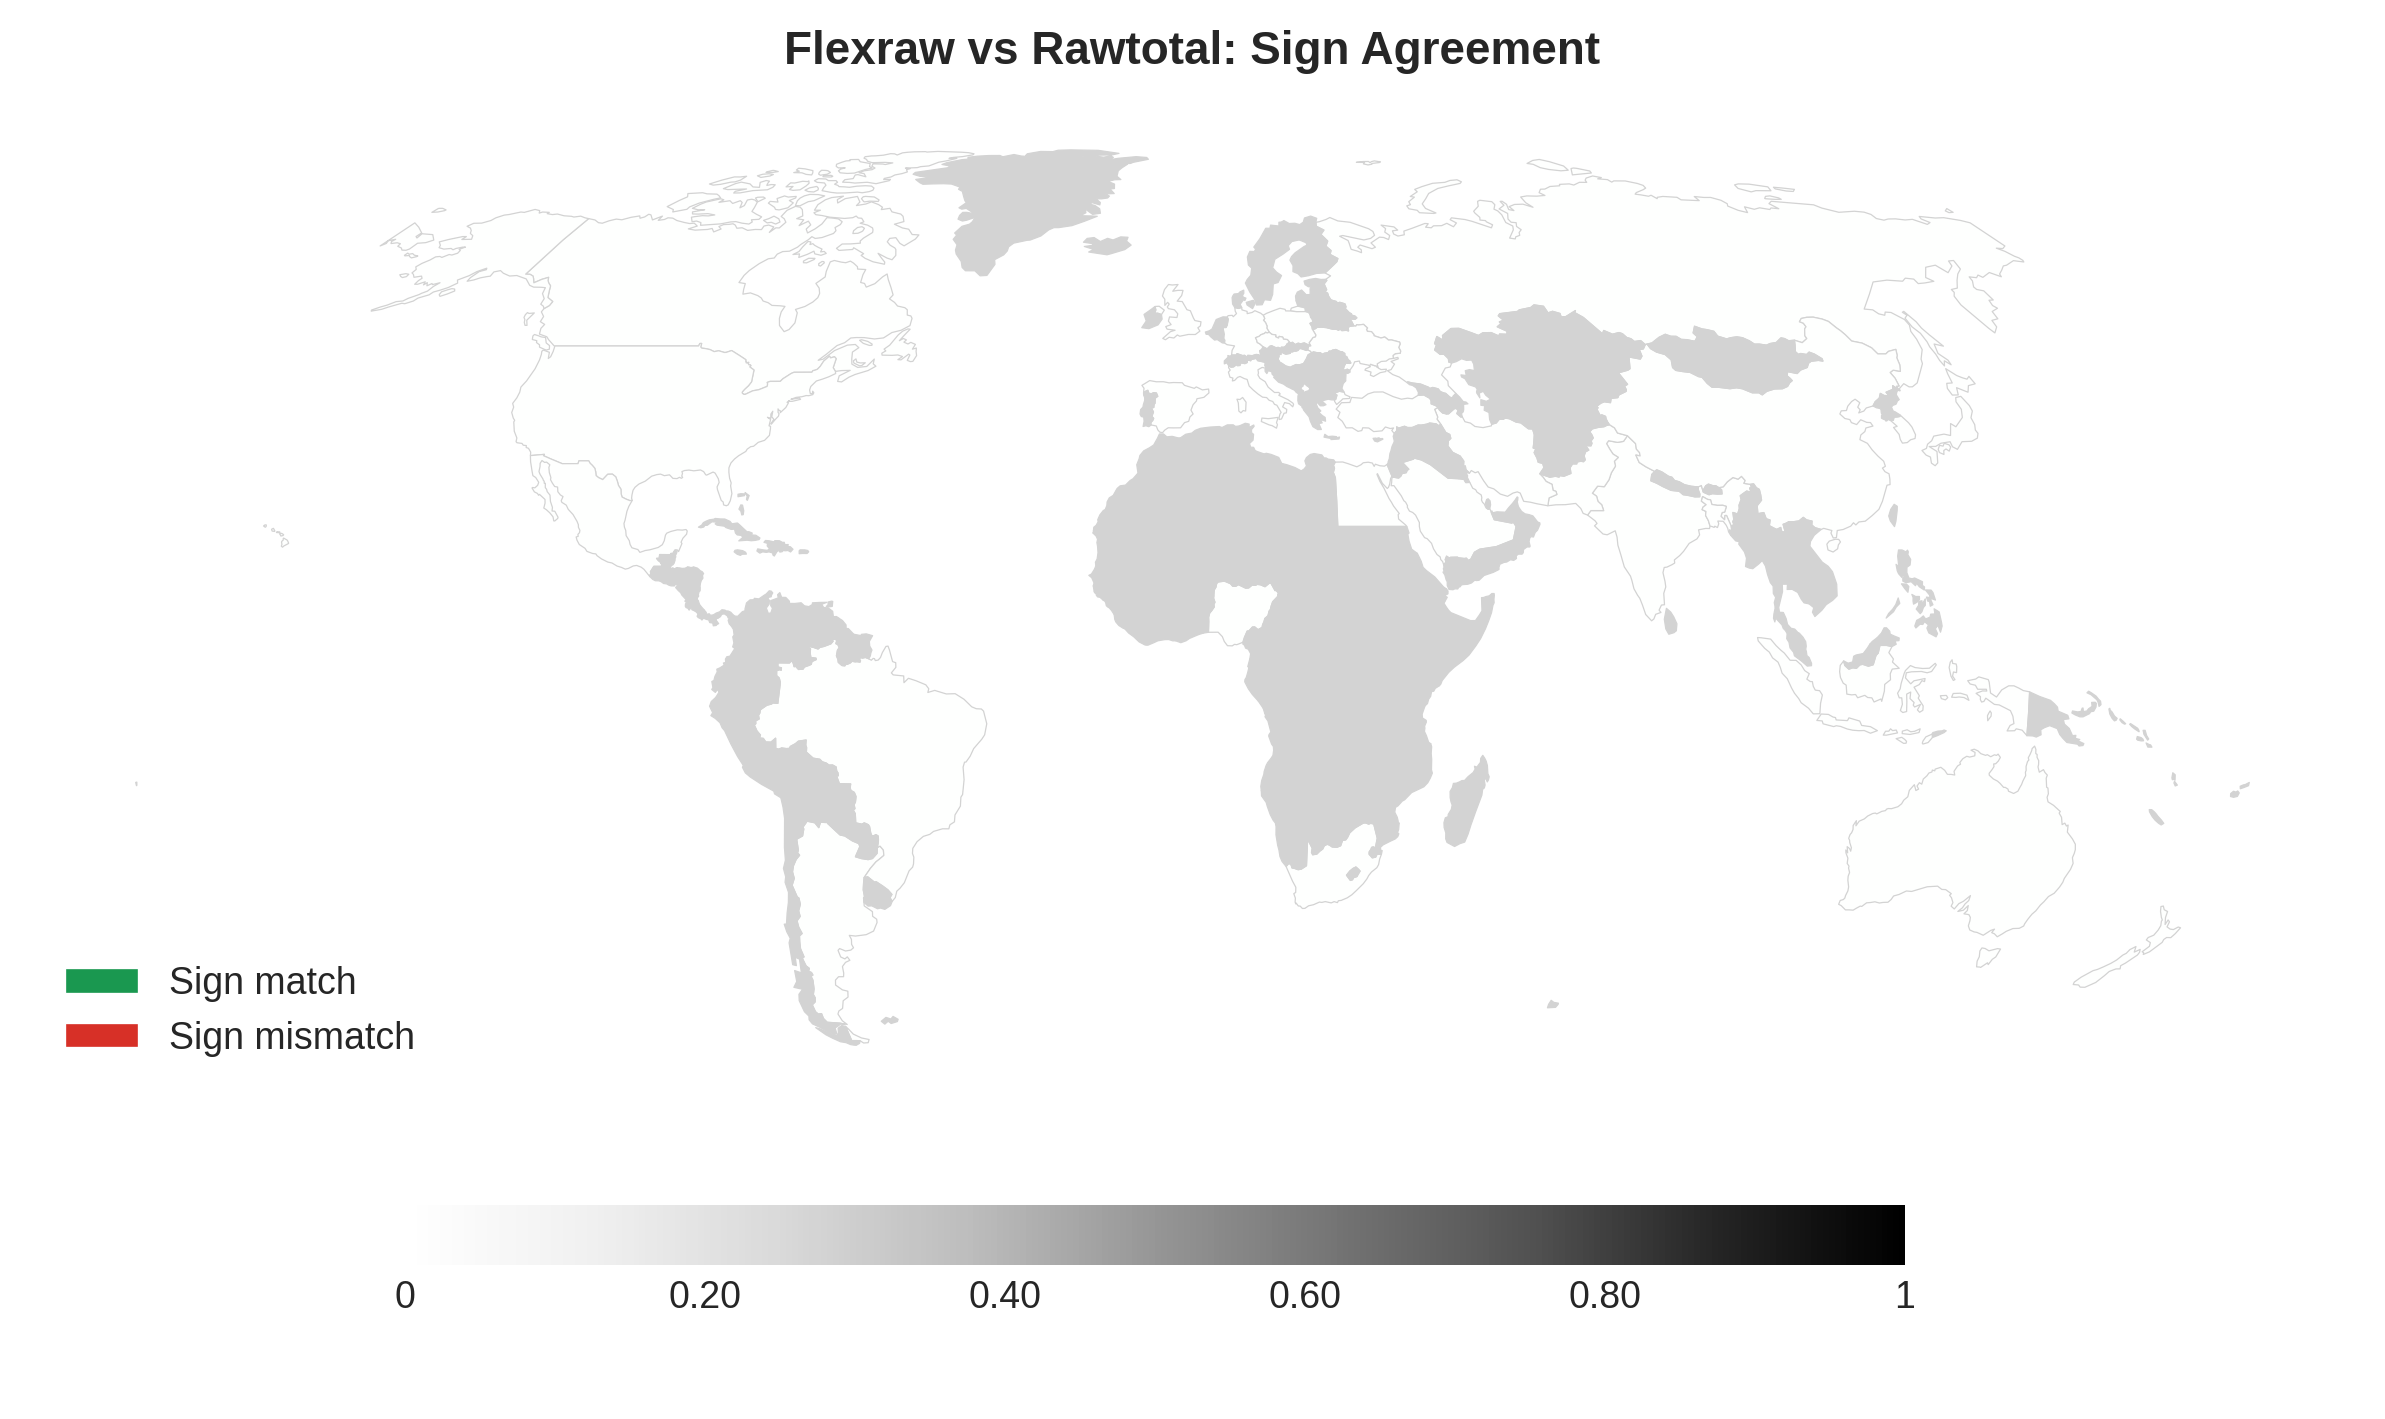

In [26]:
# Generate comparison map: flexraw vs rawtotal
out_path = map_viz.plot_comparison_map(
    data=f2_country,
    value_col_a="flexraw",
    geo_id_col="iso3",
    geo_level="country",
    title="Flexraw vs Rawtotal: Sign Agreement",
    filename="comparison_map.png"
)

if out_path:
    display(Image(filename=out_path))

### 8.3 Map Statistics

Each map automatically generates a statistics CSV file with top/bottom regions.

In [27]:
# List generated map files
import os
print("Generated map outputs:")
for f in sorted(os.listdir(maps_dir)):
    print(f"  - {f}")

# Display stats from the country damage map
stats_file = maps_dir / "country_damage_map_stats.csv"
if stats_file.exists():
    print("\n=== Country Damage Map Statistics ===")
    stats_df = pd.read_csv(stats_file)
    display(stats_df)

Generated map outputs:
  - comparison_map.png
  - comparison_map_stats.csv
  - country_damage_map.png
  - country_damage_map_stats.csv

=== Country Damage Map Statistics ===


iso3   flexraw   Category
0   NGA -0.001968  Bottom 10
1   MEX  0.013063  Bottom 10
2   IND  0.030292  Bottom 10
3   BRA  0.041239  Bottom 10
4   CAN  0.042965  Bottom 10
5   DEU  0.043897  Bottom 10
6   PAK  0.044027  Bottom 10
7   ARG  0.044979  Bottom 10
8   GBR  0.046760  Bottom 10
9   CZE  0.048468  Bottom 10
10  NZL  0.057357     Top 10
11  IRN  0.057480     Top 10
12  CHN  0.058521     Top 10
13  BGD  0.061148     Top 10
14  SAU  0.071266     Top 10
15  JPN  0.072714     Top 10
16  ITA  0.074889     Top 10
17  IDN  0.077771     Top 10
18  AUS  0.089572     Top 10
19  ESP  0.102143     Top 10

## 9. Summary

This tutorial demonstrated the complete FlexDamage workflow:

1. **Data Generation**: Created synthetic mortality data with real ISO-3 country codes
2. **Configuration**: Defined estimation parameters including convexity constraints
3. **Preprocessing**: Aggregated data across GCMs
4. **Global Estimation**: Estimated income elasticity (Gamma)
5. **Regional Estimation**: Fitted polynomial response curves per country
6. **Diagnostics**: Generated parameter distributions, fit diagnostics, and residual plots
7. **F2 Tables**: Generated damage projections with statistics
8. **Map Visualizations**: Created choropleth and comparison maps

### Key Outputs

| Output | Location |
|--------|----------|
| Regional Parameters | `results/regional_results.csv` |
| F2 Projections | `results/f2/f2_projections.csv` |
| Diagnostic Plots | `results/diagnostics/` |
| Map Visualizations | `results/maps/` |

### Next Steps

- See `map_visualization_tutorial.ipynb` for advanced map features including animated GIFs
- Explore the `DiagnosticVisualizer` API for additional plot customization
- Use real data with actual climate projections for production analysis

In [28]:
# Final list of all generated outputs
print("=" * 60)
print("ALL GENERATED OUTPUTS")
print("=" * 60)

def list_dir_recursive(path, prefix=""):
    """List directory contents recursively."""
    if path.is_dir():
        for item in sorted(path.iterdir()):
            if item.name.startswith('.'):
                continue
            if item.is_dir():
                print(f"{prefix}{item.name}/")
                list_dir_recursive(item, prefix + "  ")
            else:
                print(f"{prefix}{item.name}")

list_dir_recursive(base_dir)
print("=" * 60)

ALL GENERATED OUTPUTS
config.yaml
data/
  mock_mortality.csv
results/
  diagnostics/
    crossing_zero.png
    economic_damage_relationship.png
    fit_diagnostics_10.png
    fit_diagnostics_6.png
    gamma_distribution.png
    global_residuals_time.png
    maxslope_hist.png
    param_distributions.png
    polynomial_summary.png
    regional_curves.png
    residuals_diagnostic.png
    temperature_damage_relationship.png
    worst_offenders_detail.png
  f2/
    f2_projections.csv
  maps/
    comparison_map.png
    comparison_map_stats.csv
    country_damage_map.png
    country_damage_map_stats.csv
  regional_results.csv
